# Ajustes iniciales

## Conexión a drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd ./drive/MyDrive/Colab Notebooks

/content/drive/MyDrive/Colab Notebooks


In [3]:
%pwd

'/content/drive/MyDrive/Colab Notebooks'

## Importar los módulos *_utils

In [5]:
import sys
sys.path.append('/content/drive/My Drive/Colab Notebooks/')
from my_utils import dataset_utils
from my_utils import eval_utils
from my_utils import nn_utils
from my_utils import results_utils

import pickle

## UTILS

### plotHistories()

In [69]:
from matplotlib import pyplot as plt
import pandas as pd

fig_width = 15
figure_height = 6

def plotHistories(histories_list, fig_title, columns_titles, figure_size='display_size',
                  y_limits='auto', plot_mov_avg=False, rolling_window=5, plot_best_epoch=False,
                  plot_mean_val_acc=False, save_figure=False, file_name='', hide_figure=False):

  # set figure dimensions
  fig_width, figure_height = setSizeVariables(figure_size, len(histories_list))
  
  # find the epoch with the highest mean_val_acc
  best_epoch = 0
  if plot_best_epoch:
    mean_val_acc = computeMeanValAcc(histories_list)
    best_epoch = mean_val_acc.index(max(mean_val_acc))

  fig, ax = plt.subplots(2, len(histories_list), figsize=(fig_width, figure_height))

  # set y labels (just in the first ax of each row)
  ax[0, 0].set_ylabel('loss')
  ax[1, 0].set_ylabel('acc')

  if y_limits == 'auto':
    max_loss = 0
    min_loss = 1
    max_acc = 0
    min_acc = 1
  else:
    min_loss, max_loss = y_limits['loss']
    min_acc, max_acc = y_limits['acc']

  for i, model_history in enumerate(histories_list):
    df = pd.DataFrame(model_history)

    if y_limits == 'auto':
      max_loss = max(max_loss, df['loss'].max(), df['val_loss'].max())
      max_acc  = max(max_acc, df['acc'].max(), df['val_acc'].max())
      min_loss = min(min_loss, df['loss'].min(), df['val_loss'].min())
      min_acc  = min(min_acc, df['acc'].min(), df['val_acc'].min())

    if plot_mov_avg:
      df['val_acc_SMA'] = df['val_acc'].rolling(window=rolling_window).mean()
      df['val_loss_SMA'] = df['val_loss'].rolling(window=rolling_window).mean()

    # plot the loss curves
    ax[0, i].plot(model_history['loss'])
    ax[0, i].plot(model_history['val_loss'])
    if plot_mov_avg:
      ax[0, i].plot(df['val_loss_SMA'])
    
    if columns_titles:
      ax[0, i].set_title(columns_titles[i])

    if i == len(histories_list)-1:
      ax[0, i].legend(['train', 'val'], loc='upper right')

    #ax[0, i].set_ylabel('loss')
    #ax[0, i].set_xlabel('epoch')
    #ax1.set_ylim(.2, 1.2)
    #ax.set_legend(['train', 'val'], loc='upper left')
    #plt.show()
    
    # plot accuracy curves
    ax[1, i].plot(model_history['acc'])
    ax[1, i].plot(model_history['val_acc'])

    max_val_acc = max(model_history['val_acc'])
    max_epoch = model_history['val_acc'].index(max_val_acc)

    ax[1, i].plot(max_epoch, max_val_acc, 'or')

    if plot_mean_val_acc:
      ax[1, i].plot(mean_val_acc)
    if plot_best_epoch:
      ax[1, i].vlines([best_epoch], ymin=0.55, ymax=1, label='best_epoch')

    if plot_mov_avg:
      ax[1, i].plot(df['val_acc_SMA'])

    ax[1, i].set_xlabel('epoch')
    #ax[1, i].set_title('model acc')
    #ax[1, i].set_ylabel('acc')
    
    #ax2.set_ylim(.55, .95)
    #ax.set_legend(['train', 'val'], loc='upper left')
    #plt.show()

    if i == len(histories_list)-1:
      legends_list = ['train', 'val', 'max_val_acc']
      if plot_mean_val_acc:
        legends_list.append('mean_val_acc')
      
      if plot_best_epoch:
        legends_list.append(f'best_epoch={best_epoch}')
      
      ax[1, i].legend(legends_list, loc='upper right')
      

  for i in range(len(histories_list)):
    ax[0, i].set_ylim(max(0, min_loss - 0.05), max_loss + 0.15)
    ax[1, i].set_ylim(0.55, 1)

  fig.suptitle(fig_title)
  #plt.show()

  if save_figure:
    fig.savefig(f'./history_plots/{file_name}.png')

  if hide_figure:
    plt.close(fig)

print('plotting is complete')

plotting is complete


### setSizeVariables

In [63]:
def setSizeVariables(figure_size, n_histories):
  fig_width = 15
  figure_height = 6

  if figure_size == 'printable_horizontal':
    fig_width = 7
    figure_height = n_histories*3
    plt.rc('font', size=12)          # controls default text sizes
    plt.rc('axes', titlesize=14)     # fontsize of the axes title
    plt.rc('axes', labelsize=14)     # fontsize of the x and y labels
    plt.rc('xtick', labelsize=12)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=12)    # fontsize of the tick labels
    plt.rc('legend', fontsize=12)    # legend fontsize
    plt.rc('figure', titlesize=20)  # fontsize of the figure title


  if figure_size == 'printable_size':
    fig_width = 15
    figure_height = 6
    plt.rc('font', size=12)          # controls default text sizes
    plt.rc('axes', titlesize=14)     # fontsize of the axes title
    plt.rc('axes', labelsize=14)     # fontsize of the x and y labels
    plt.rc('xtick', labelsize=12)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=12)    # fontsize of the tick labels
    plt.rc('legend', fontsize=12)    # legend fontsize
    plt.rc('figure', titlesize=20)  # fontsize of the figure title

  if figure_size == 'display_size':
    if n_histories > 4:
      fig_width = 8*n_histories
      figure_height = 12
    else:
      fig_width = 30
      figure_height = 12

    plt.rc('font', size=12)          # controls default text sizes
    plt.rc('axes', titlesize=17)     # fontsize of the axes title
    plt.rc('axes', labelsize=17)     # fontsize of the x and y labels
    plt.rc('xtick', labelsize=12)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=12)    # fontsize of the tick labels
    plt.rc('legend', fontsize=12)    # legend fontsize
    plt.rc('figure', titlesize=22)  # fontsize of the figure title
  
  return fig_width, figure_height

In [10]:
from statistics import mean
def computeMeanValAcc(histories_list):
  val_acc_zip = list(zip(*[h['val_acc'] for h in histories_list]))
  n_epochs = len(val_acc_zip)
  mean_val_acc = []

  for i in range(n_epochs):
    mean_val_acc.append(mean(val_acc_zip[i]))

  return mean_val_acc
      

In [ ]:
import pickle
ids_list = ['vNIrvuRV',]

for conf_id in ids_list[:]:
  with open(f'./history_files/{conf_id}.dict', 'rb') as file_handler:
      histories_list = pickle.load(file_handler)

  fig_title = f''

  histories2plot = [hist for i,hist in enumerate(histories_list) if i in [0,4,6]]
  plotAccHistories(histories2plot, 
                  fig_title,
                  columns_titles=['Iteración 1', 'Iteración 2', 'Iteración 3'], 
                  figure_size='printable_horizontal',
                  y_limits={'loss':[0,2.5], 'acc':[.55, 1]},
                  plot_mov_avg=False,
                  plot_best_epoch=True,
                   plot_mean_val_acc=True)

### plotAccHistory() [VERTICAL]

In [84]:
from matplotlib import pyplot as plt
import pandas as pd

fig_width = 15
figure_height = 6

def plotAccHistories(histories_list, fig_title, columns_titles, figure_size='display_size',
                  y_limits='auto', plot_mov_avg=False, rolling_window=5, plot_best_epoch=False,
                  plot_mean_val_acc=False, save_figure=False, file_name='', hide_figure=False):

  # set figure dimensions
  fig_width, figure_height = setSizeVariables(figure_size, len(histories_list))
  
  # find the epoch with the highest mean_val_acc
  best_epoch = 0
  if plot_best_epoch:
    mean_val_acc = computeMeanValAcc(histories_list)
    best_epoch = mean_val_acc.index(max(mean_val_acc))

  # fig, ax = plt.subplots(len(histories_list),1, figsize=(fig_width, figure_height/2))
  fig, ax = plt.subplots(len(histories_list),1, figsize=(fig_width, figure_height))

  # set y labels (just in the first ax of each row)
  # ax[0, 0].set_ylabel('loss')
  ax[len(histories_list)-1].set_xlabel('Época')
  fig.tight_layout(pad=3.0)

  if y_limits == 'auto':
    max_loss = 0
    min_loss = 1
    max_acc = 0
    min_acc = 1
  else:
    min_loss, max_loss = y_limits['loss']
    min_acc, max_acc = y_limits['acc']

  for i, model_history in enumerate(histories_list):
    df = pd.DataFrame(model_history)

    if columns_titles:
      ax[i].set_title(columns_titles[i])

    if y_limits == 'auto':
      max_acc  = max(max_acc, df['acc'].max(), df['val_acc'].max())
      min_acc  = min(min_acc, df['acc'].min(), df['val_acc'].min())

    # plot accuracy curves
    ax[i].set_ylabel(f'Exactitud')

    ax[i].plot(model_history['acc'])
    ax[i].plot(model_history['val_acc'])

    # plot mean-curve
    if plot_mean_val_acc:
      ax[i].plot(mean_val_acc, alpha=0.7)

    # plot local-max
    max_val_acc = max(model_history['val_acc'])

    # plot local max
    max_epoch = model_history['val_acc'].index(max_val_acc)
    ax[i].vlines([max_epoch], ymin=0.55, ymax=1, color='red')
    #ax[i].plot(max_epoch, max_val_acc, 'or')

    # plot max in mean curve
    if plot_best_epoch:
      ax[i].vlines([best_epoch], ymin=0.55, ymax=1, label='best_epoch')

    if i == 0:
      legends_list = ['entrenamiento', 'validación']
      if plot_mean_val_acc:
        legends_list.append('curva promedio')

      legends_list.append('max-local')

      if plot_best_epoch:
        legends_list.append(f'max-curva-promedio')
      
      ax[i].legend(legends_list, loc='upper right')
      

  for i in range(len(histories_list)):
    ax[i].set_ylim(max(0, min_loss - 0.05), max_loss + 0.15)
    ax[i].set_ylim(0.55, 1)

  fig.suptitle(fig_title)
  #plt.show()

  if save_figure:
    fig.savefig(f'./history_plots/{file_name}.png')

  if hide_figure:
    plt.close(fig)

print('plotting is complete')

plotting is complete


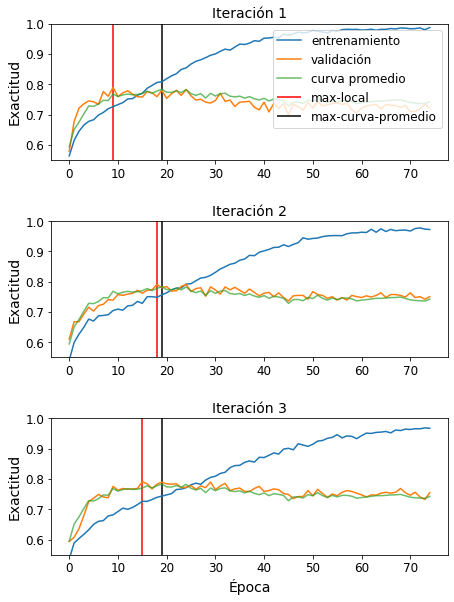

In [85]:
import pickle
ids_list = ['vNIrvuRV',]

for conf_id in ids_list[:]:
  with open(f'./history_files/{conf_id}.dict', 'rb') as file_handler:
      histories_list = pickle.load(file_handler)

  fig_title = f''

  histories2plot = [hist for i,hist in enumerate(histories_list) if i in [0,3,6]]
  plotAccHistories(histories2plot, 
                  fig_title,
                  columns_titles=['Iteración 1', 'Iteración 2', 'Iteración 3'], 
                  figure_size='printable_horizontal',
                  y_limits={'loss':[0,2.5], 'acc':[.55, 1]},
                  plot_mov_avg=False,
                  plot_best_epoch=True,
                   plot_mean_val_acc=True)

### plotAccHistory() [HORIZONTAL]

In [19]:
from matplotlib import pyplot as plt
import pandas as pd

fig_width = 15
figure_height = 6

def plotAccHistories(histories_list, fig_title, columns_titles, figure_size='display_size',
                  y_limits='auto', plot_mov_avg=False, rolling_window=5, plot_best_epoch=False,
                  plot_mean_val_acc=False, save_figure=False, file_name='', hide_figure=False):

  # set figure dimensions
  fig_width, figure_height = setSizeVariables(figure_size, len(histories_list))
  
  # find the epoch with the highest mean_val_acc
  best_epoch = 0
  if plot_best_epoch:
    mean_val_acc = computeMeanValAcc(histories_list)
    best_epoch = mean_val_acc.index(max(mean_val_acc))

  fig, ax = plt.subplots(1, len(histories_list), figsize=(fig_width, figure_height/2))

  # set y labels (just in the first ax of each row)
  # ax[0, 0].set_ylabel('loss')
  ax[0].set_ylabel('exactitud')

  if y_limits == 'auto':
    max_loss = 0
    min_loss = 1
    max_acc = 0
    min_acc = 1
  else:
    min_loss, max_loss = y_limits['loss']
    min_acc, max_acc = y_limits['acc']

  for i, model_history in enumerate(histories_list):

    df = pd.DataFrame(model_history)

    if y_limits == 'auto':
      max_acc  = max(max_acc, df['acc'].max(), df['val_acc'].max())
      min_acc  = min(min_acc, df['acc'].min(), df['val_acc'].min())

    if plot_mov_avg:
      df['val_acc_SMA'] = df['val_acc'].rolling(window=rolling_window).mean()
   
    if columns_titles:
      ax[i].set_title(columns_titles[i])

    # plot accuracy curves
    ax[i].plot(model_history['acc'])
    ax[i].plot(model_history['val_acc'])

    max_val_acc = max(model_history['val_acc'])
    max_epoch = model_history['val_acc'].index(max_val_acc)

    ax[i].plot(max_epoch, max_val_acc, 'or')

    if plot_mean_val_acc:
      ax[i].plot(mean_val_acc)
    if plot_best_epoch:
      ax[i].vlines([best_epoch], ymin=0.55, ymax=1, label='best_epoch')

    if plot_mov_avg:
      ax[i].plot(df['val_acc_SMA'])

    ax[i].set_xlabel('época')

    if i == len(histories_list)-1:
      legends_list = ['train', 'val', 'max curva-promedio']
      if plot_mean_val_acc:
        legends_list.append('curva promedio')
      
      if plot_best_epoch:
        legends_list.append(f'max-local (época={best_epoch})')
      
      ax[i].legend(legends_list, loc='upper right')
      

  for i in range(len(histories_list)):
    ax[i].set_ylim(max(0, min_loss - 0.05), max_loss + 0.15)
    ax[i].set_ylim(0.55, 1)

  fig.suptitle(fig_title)
  #plt.show()

  if save_figure:
    fig.savefig(f'./history_plots/{file_name}.png')

  if hide_figure:
    plt.close(fig)

print('plotting is complete')

plotting is complete


# PRUEBAS

In [ ]:
files_list = ['./Results/SNN/HS/experiments_4.df']

merged_results = results_utils.mergeDataFrames(files_list, 
              './Results/SNN/FT3_embeddings_experiments.df') 

In [6]:
import pickle
with open('./Results/SNN/HS/experiments_4.df', 'rb') as file_handler:
  results_df = pickle.load(file_handler)

In [ ]:
results_df.sort_values(by='val_acc_B', ascending=False, inplace=True)
results_df.head()

conf_ID  units_lstm dense_layers_sizes  ... max2best  train_acc_B  val_acc_B
16  mSNkojaj         150         (300, 100)  ...       36     0.702968   0.761991
8   RSBGSVLB         150         (330, 100)  ...       57     0.716036   0.761292
35  mKTqklhD         150         (230, 100)  ...       72     0.725546   0.760594
26  DwGbjdYC         150         (270, 100)  ...       60     0.710494   0.759892
41  rwkkExQE         150         (200, 100)  ...       48     0.711427   0.758494

[5 rows x 16 columns]

In [12]:
results_df['conf_ID'].head().to_list()

['vNIrvuRV', 'kcYWKVRq', 'TnOkCtey', 'GqWCDvpZ', 'MwlBEYyQ']

In [ ]:
optimizer_mask = results_df['optimizer']=='adam-5e-4'
bs_mask = results_df['batch_size']==1024

results_subset = results_df.loc[optimizer_mask & bs_mask]

#results_subset.sort_values(by='val_acc_A', ascending=False)
results_subset.head()

In [ ]:
results_subset['conf_ID'].head().to_list()

['OjoIWSOf', 'wejJSpsI', 'hcKOSQiP', 'QdTPAfWN', 'iaRDmlnA']

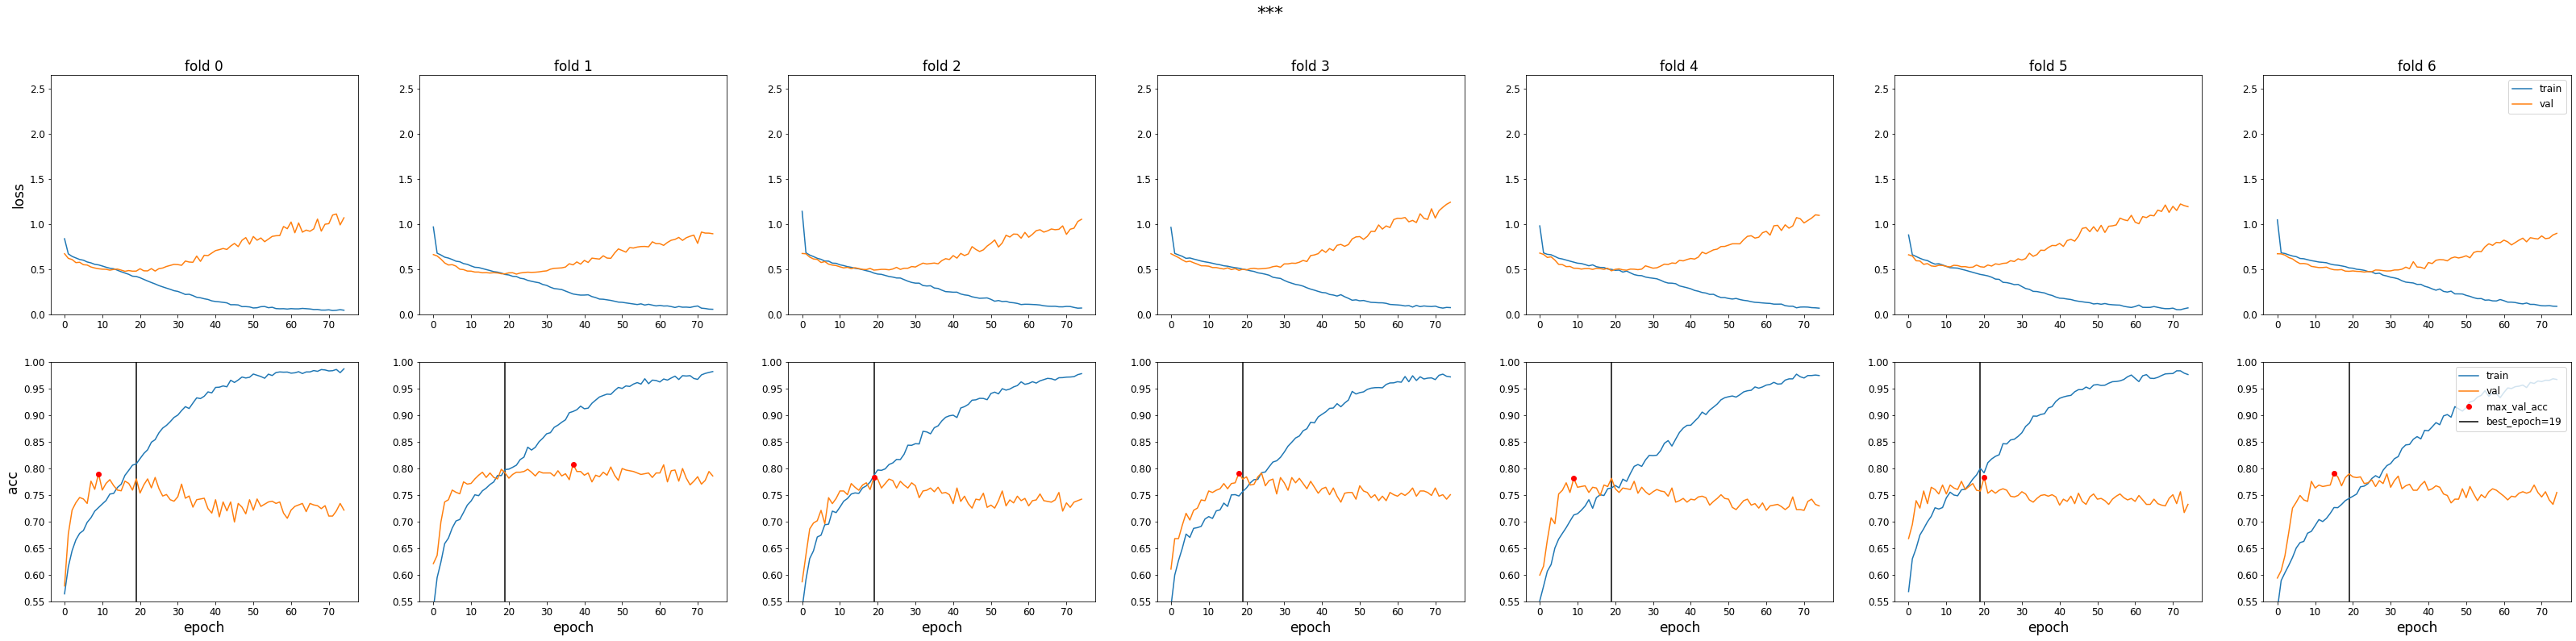

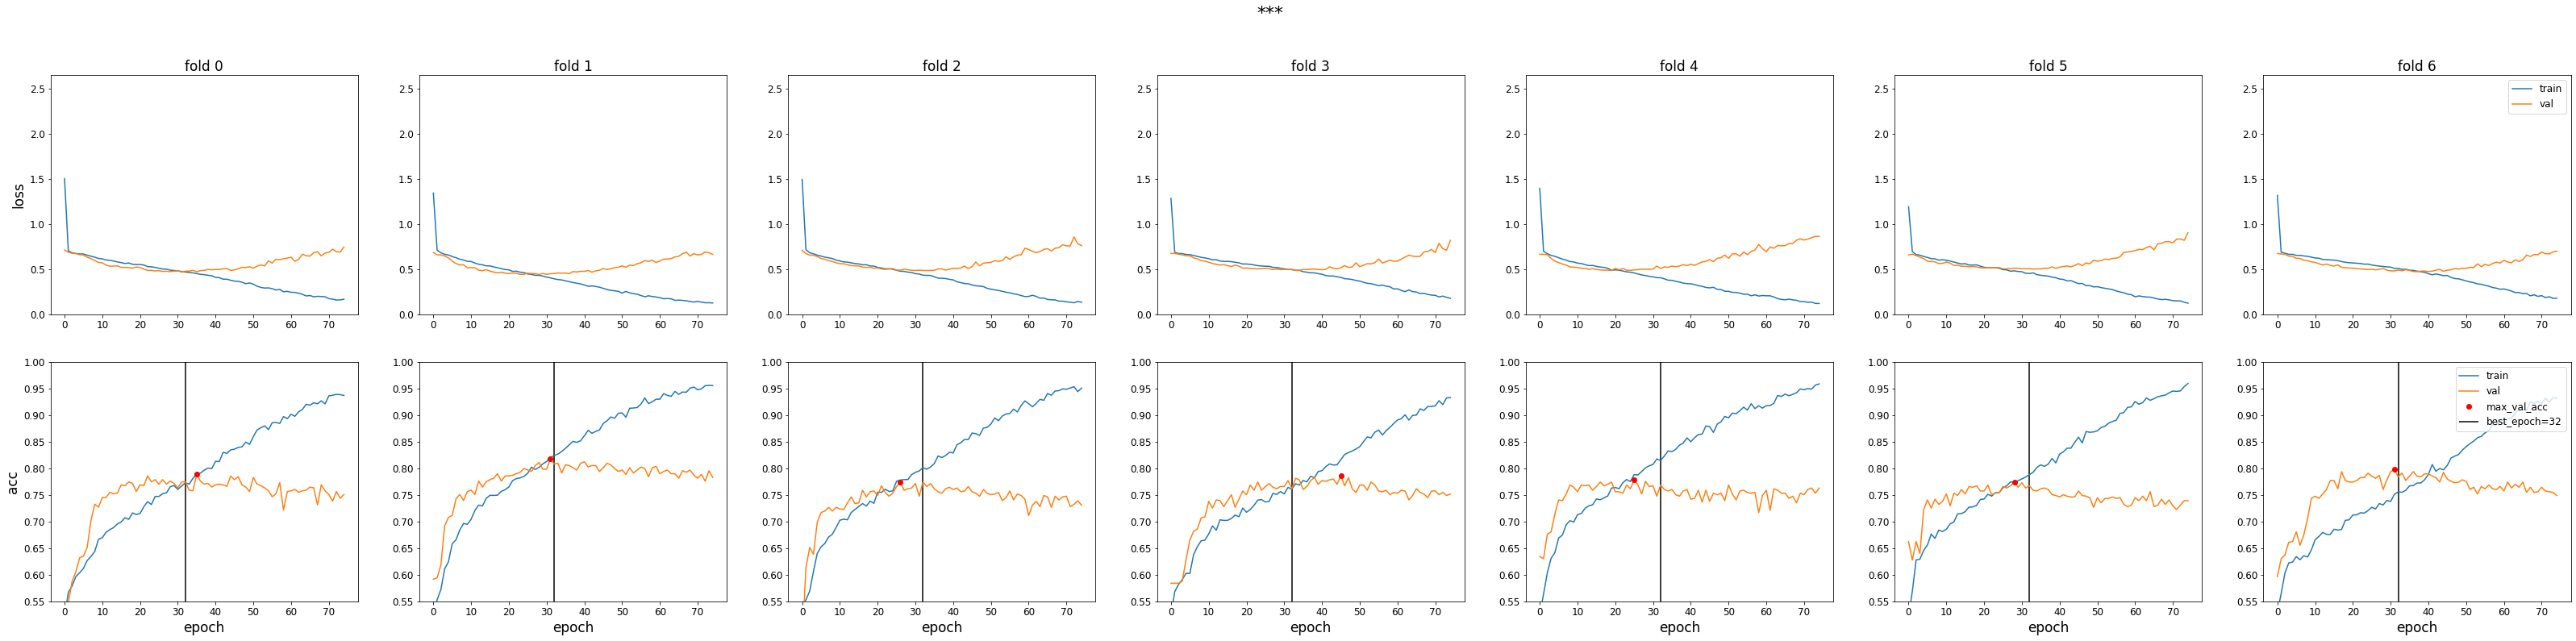

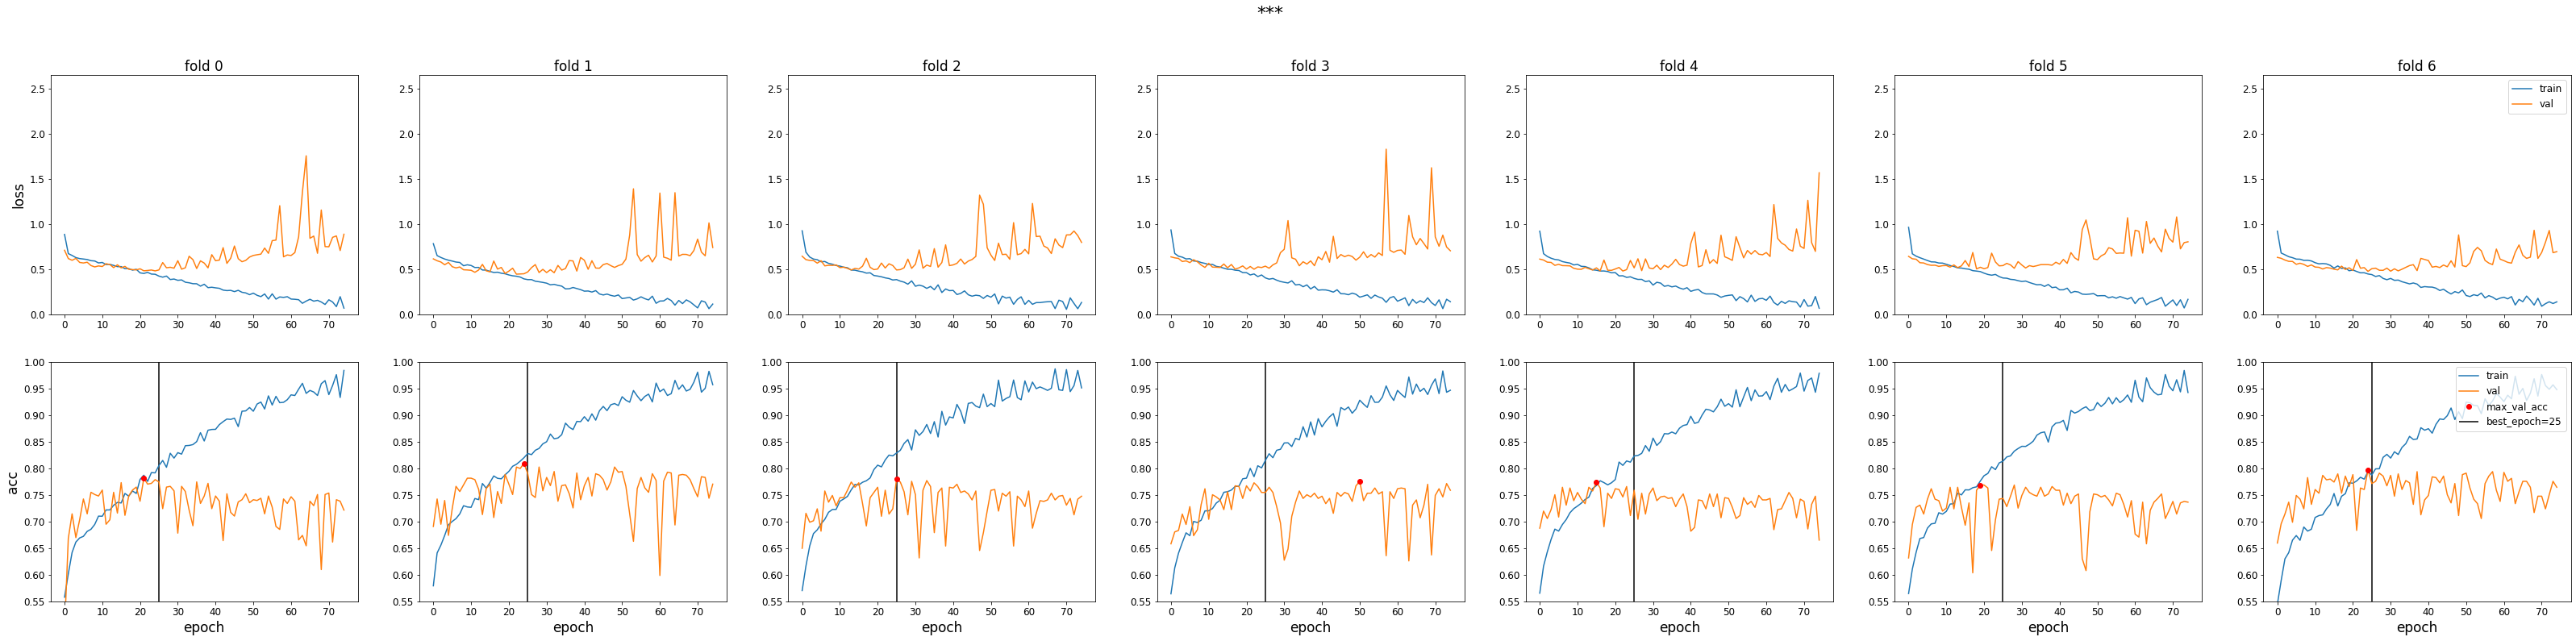

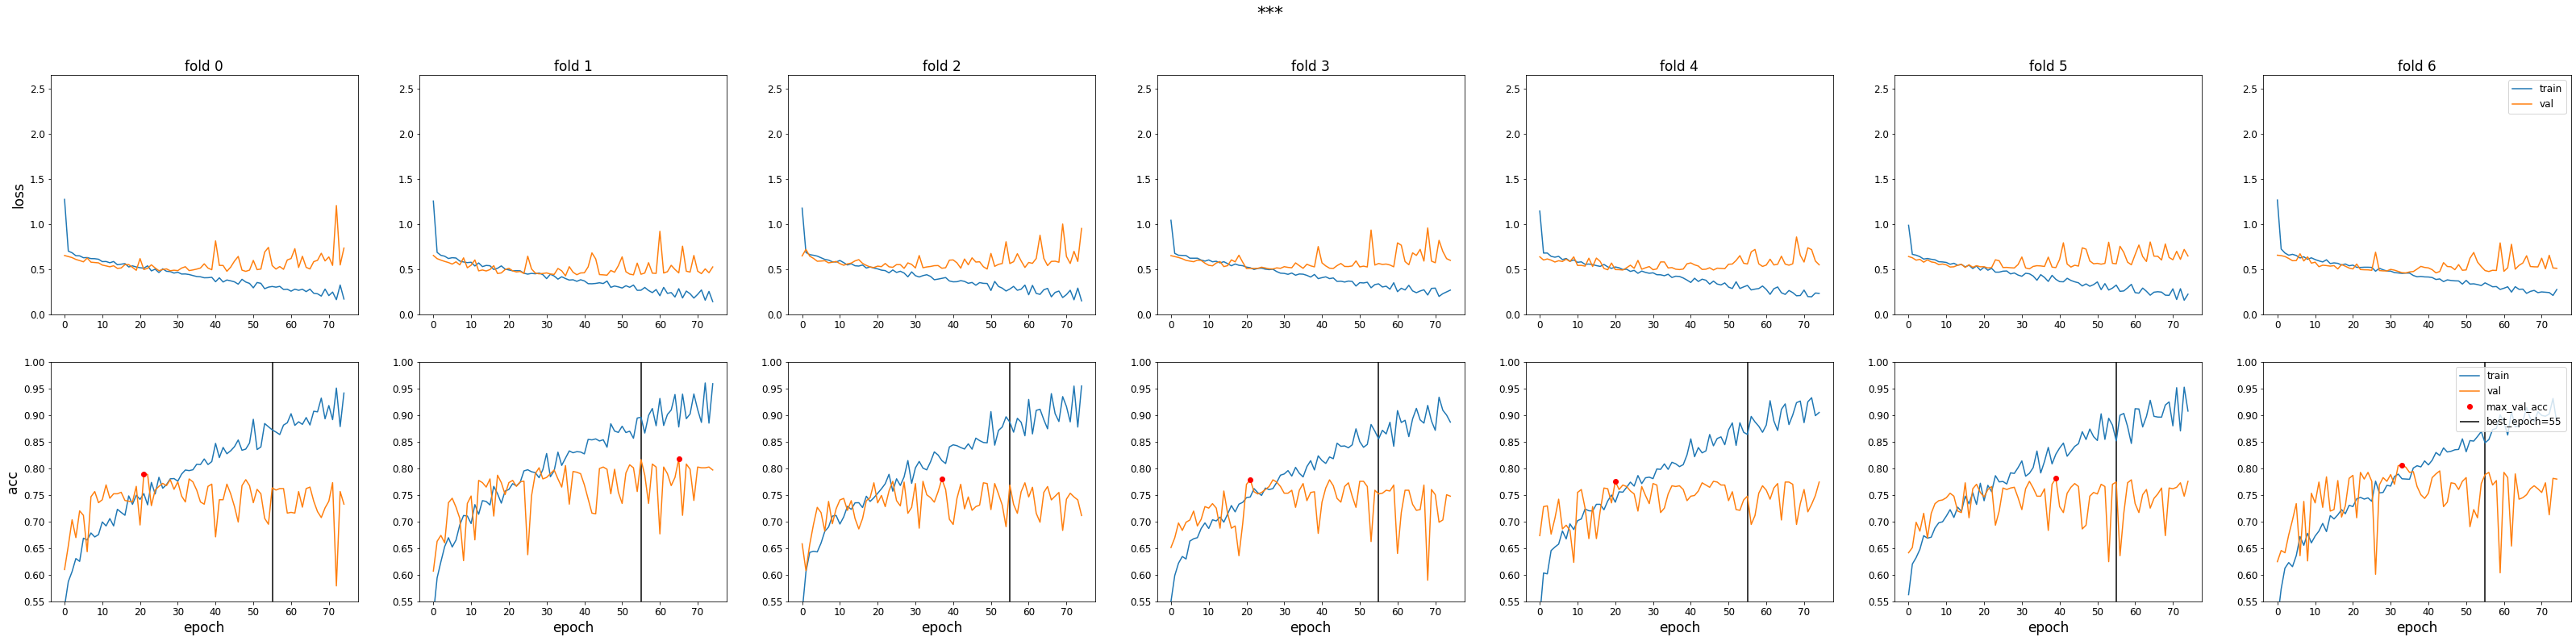

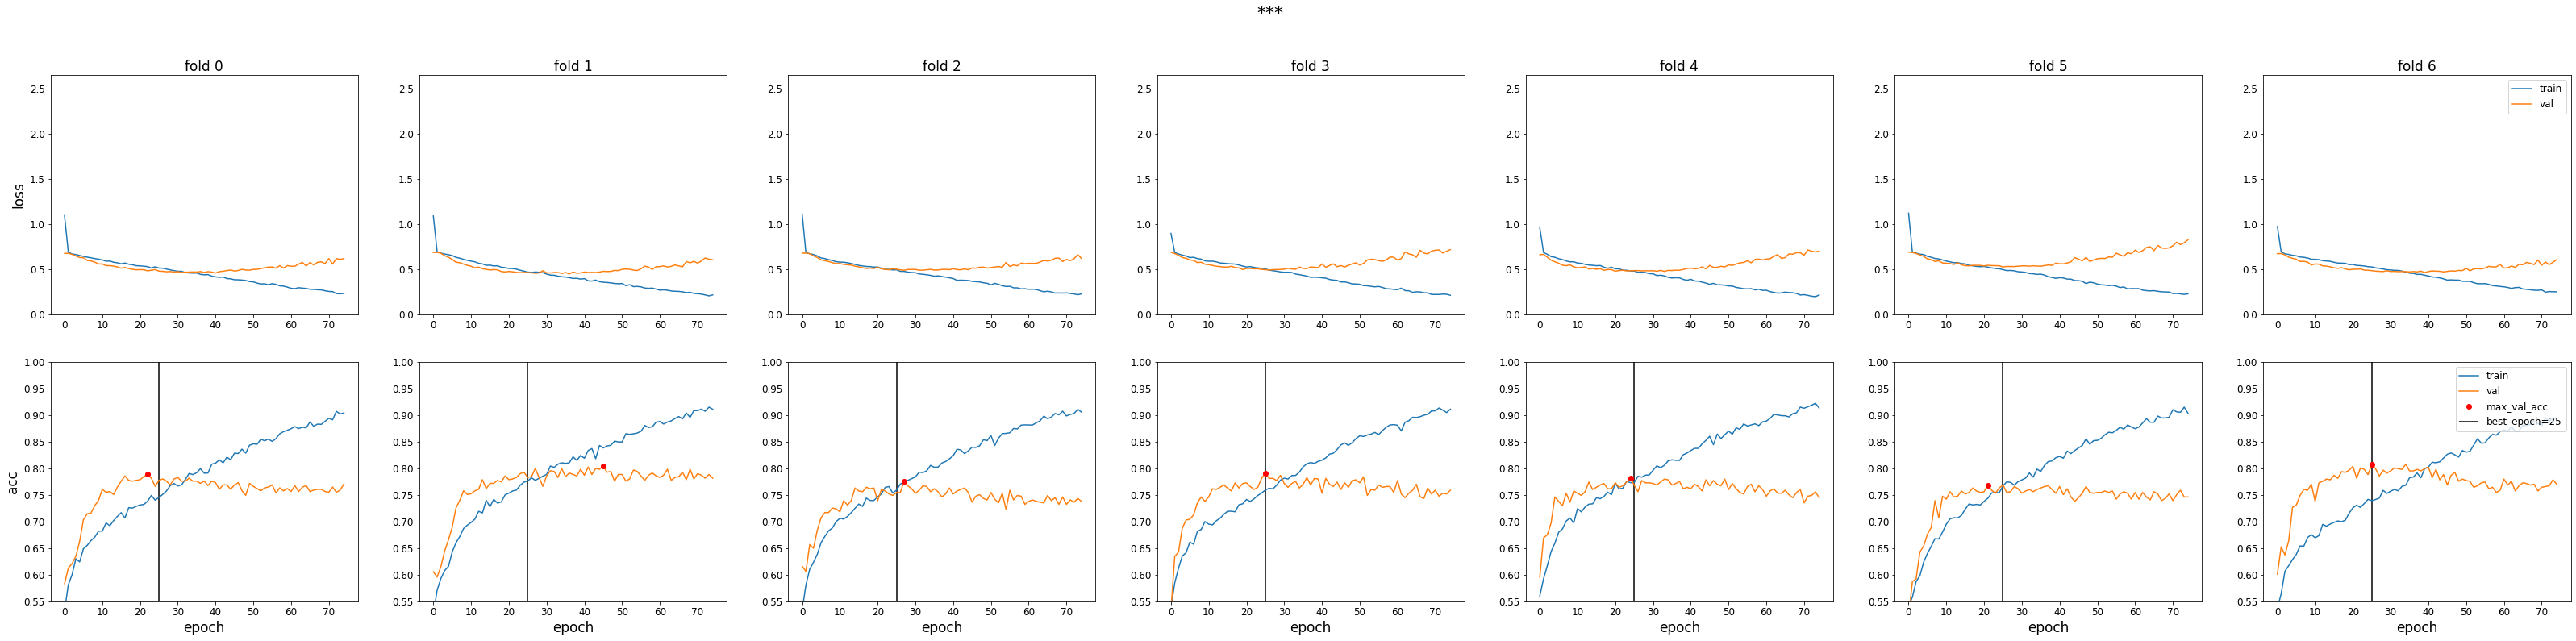

In [70]:
import pickle
ids_list = ['vNIrvuRV', 'kcYWKVRq', 'TnOkCtey', 'GqWCDvpZ', 'MwlBEYyQ']

for conf_id in ids_list[:]:
  with open(f'./history_files/{conf_id}.dict', 'rb') as file_handler:
      histories_list = pickle.load(file_handler)

  fig_title = f'***'

  plotHistories(histories_list, 
                  fig_title,
                  columns_titles=['fold 0', 'fold 1', 'fold 2', 'fold 3', 'fold 4', 'fold 5', 'fold 6', 'fold 7'], 
                  figure_size='display_size',
                  y_limits={'loss':[0,2.5], 'acc':[.55, 1]},
                plot_mov_avg=False,
                plot_best_epoch=True)

In [ ]:
plotAcc

In [ ]:
import pickle
ids_list = ['vNIrvuRV',]

for conf_id in ids_list[:]:
  with open(f'./history_files/{conf_id}.dict', 'rb') as file_handler:
      histories_list = pickle.load(file_handler)

  fig_title = f'***'

  plotAccHistories(histories_list, 
                  fig_title,
                  columns_titles=['fold 0', 'fold 1', 'fold 2', 'fold 3', 'fold 4', 'fold 5', 'fold 6', 'fold 7'], 
                  figure_size='display_size',
                  y_limits={'loss':[0,2.5], 'acc':[.55, 1]},
                plot_mov_avg=False,
                plot_best_epoch=True)

In [ ]:
files_list = ['./Results/SNN/W2V300_embeddings_experiments_batch_1.df',
            './Results/SNN/W2V300_embeddings_experiments_batch_2.df',]

merged_results = results_utils.mergeDataFrames(files_list, 
              './Results/SNN/W2V300_embeddings_experiments.df') 

In [ ]:
merged_results.shape

(216, 13)

In [ ]:
merged_results.sort_values(by='val_acc_A', ascending=False, inplace=True)

In [ ]:
merged_results.head(10)

In [ ]:
merged_results['conf_ID'].tail().to_list()

['LGQVoHZK', 'sfbDRruv', 'hFUcPDSi', 'BHZihuTf', 'HVReDoek']

In [ ]:
files_list = ['./Results/SNN/GloVe300_embeddings_experiments_batch_1.df',
            './Results/SNN/GloVe300_embeddings_experiments_batch_2.df',
            './Results/SNN/GloVe300_embeddings_experiments_batch_3.df']

merged_results = results_utils.mergeDataFrames(files_list, 
              './Results/SNN/GloVe300_embeddings_experiments.df') 

In [ ]:
merged_results.shape

(216, 13)

In [ ]:
merged_results.sort_values(by='val_acc_A', ascending=False, inplace=True)

In [ ]:
merged_results.head(5)

conf_ID  L1_size  L2_size  ... val_acc_A  train_acc_B  val_acc_B
103  AWbZNULO      300       75  ...  0.704585     0.716969   0.707386
30   YEExutth      300      150  ...  0.701790     0.778047   0.714039
57   uoquGHJV      300      100  ...  0.701788     0.713820   0.711588
23   NGeoTdFq      300      150  ...  0.698638     0.713527   0.705637
68   RJrhaksu      300      100  ...  0.698638     0.709210   0.702487

[5 rows x 13 columns]

In [ ]:
merged_results['conf_ID'].head().to_list()

['AWbZNULO', 'YEExutth', 'uoquGHJV', 'NGeoTdFq', 'RJrhaksu']

In [ ]:
interval = 1.96 * ( (0.3 * (1 - 0.3)) / 1600) ** (1/2)
print('%.3f' % interval)

0.022


# Optimizers Experiments Results

## ADAM

In [ ]:
with open('./Results/CNN_ADAM_OPTIMIZER_MERGED_1.df', 'rb') as df_file:
  results_df = pickle.load(df_file)

In [ ]:
results_df.shape

(48, 17)

## plots by learning-rate

In [ ]:
ids_list = results_df[0:15:3]['conf_ID'].to_list()

In [ ]:
lr_values = ['0.001', '0.0007', '0.0005', '0.0003', '0.0001']

for idx, conf_id in enumerate(ids_list):
  with open(f'./history_files/{conf_id}.dict', 'rb') as file_handler:
    histories_list = pickle.load(file_handler)
  fig_title = f'({conf_id}) Configuración 1 - ADAM optimizer lr ={lr_values[idx]}'

  plotHistories(histories_list, 
                fig_title, 
                columns_titles=['fold 0', 'fold 2', 'fold 4', 'fold 6'], 
                figure_size='display_size',
                y_limits={'loss':[0,2.5], 'acc':[.55, 1]})

### Learning rates comparison

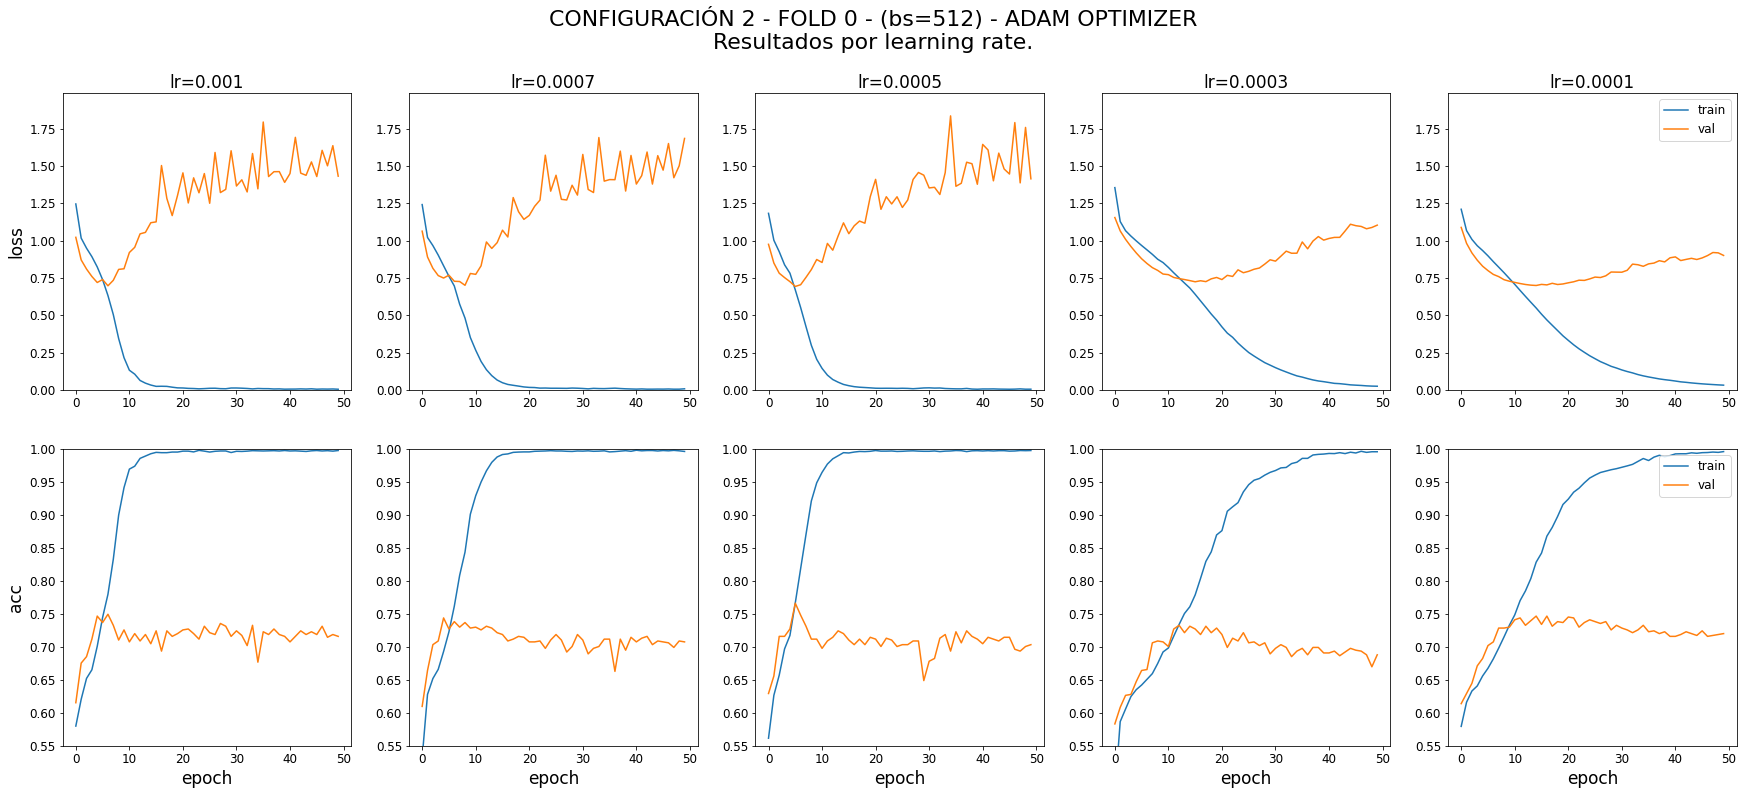

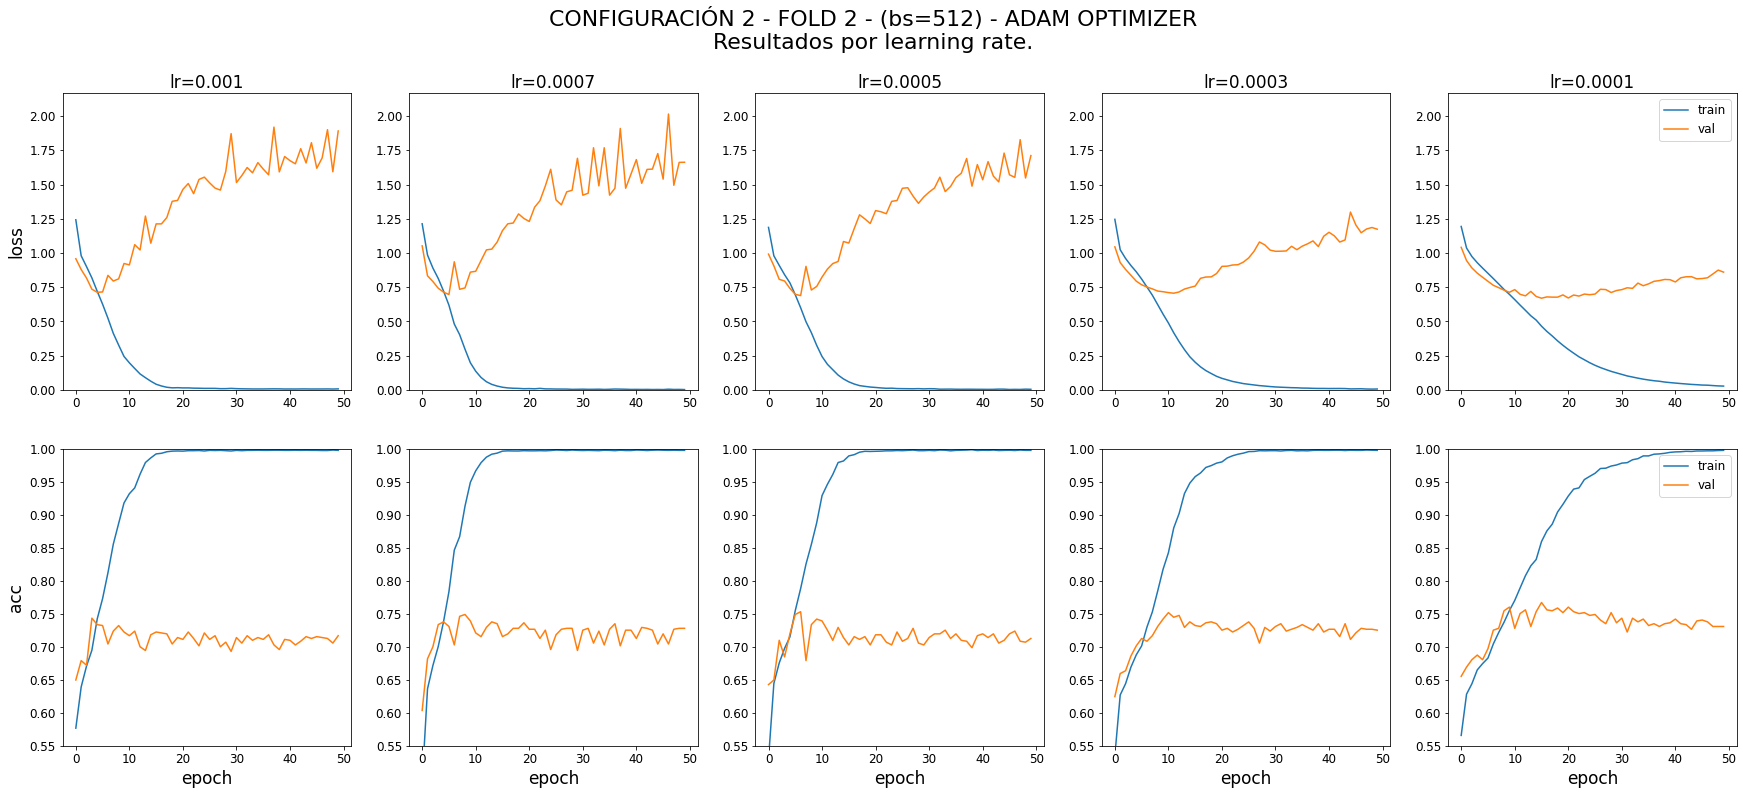

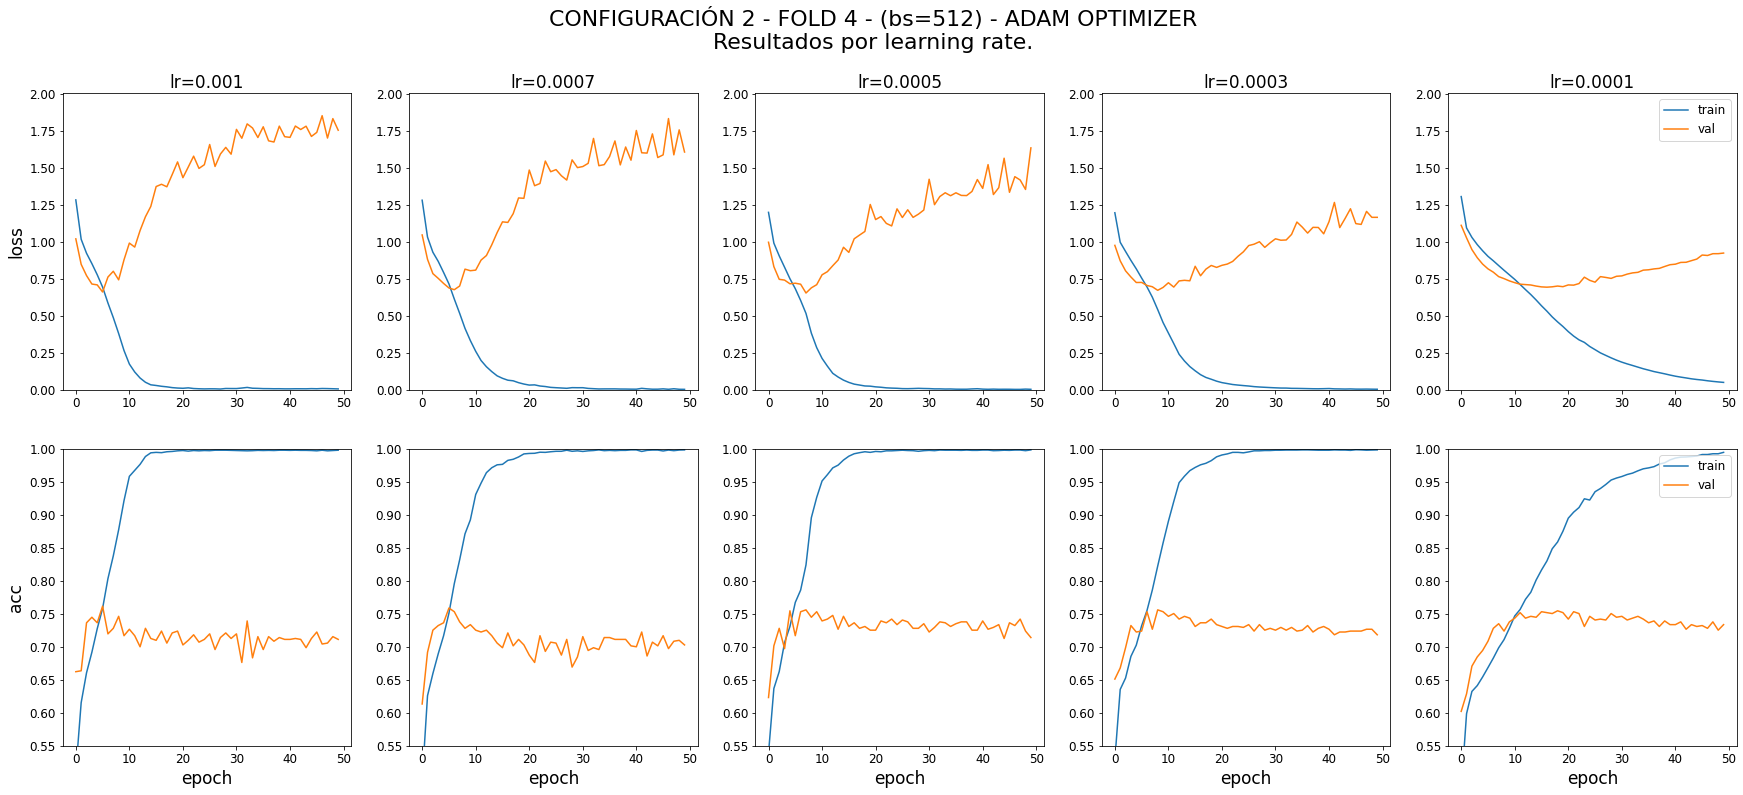

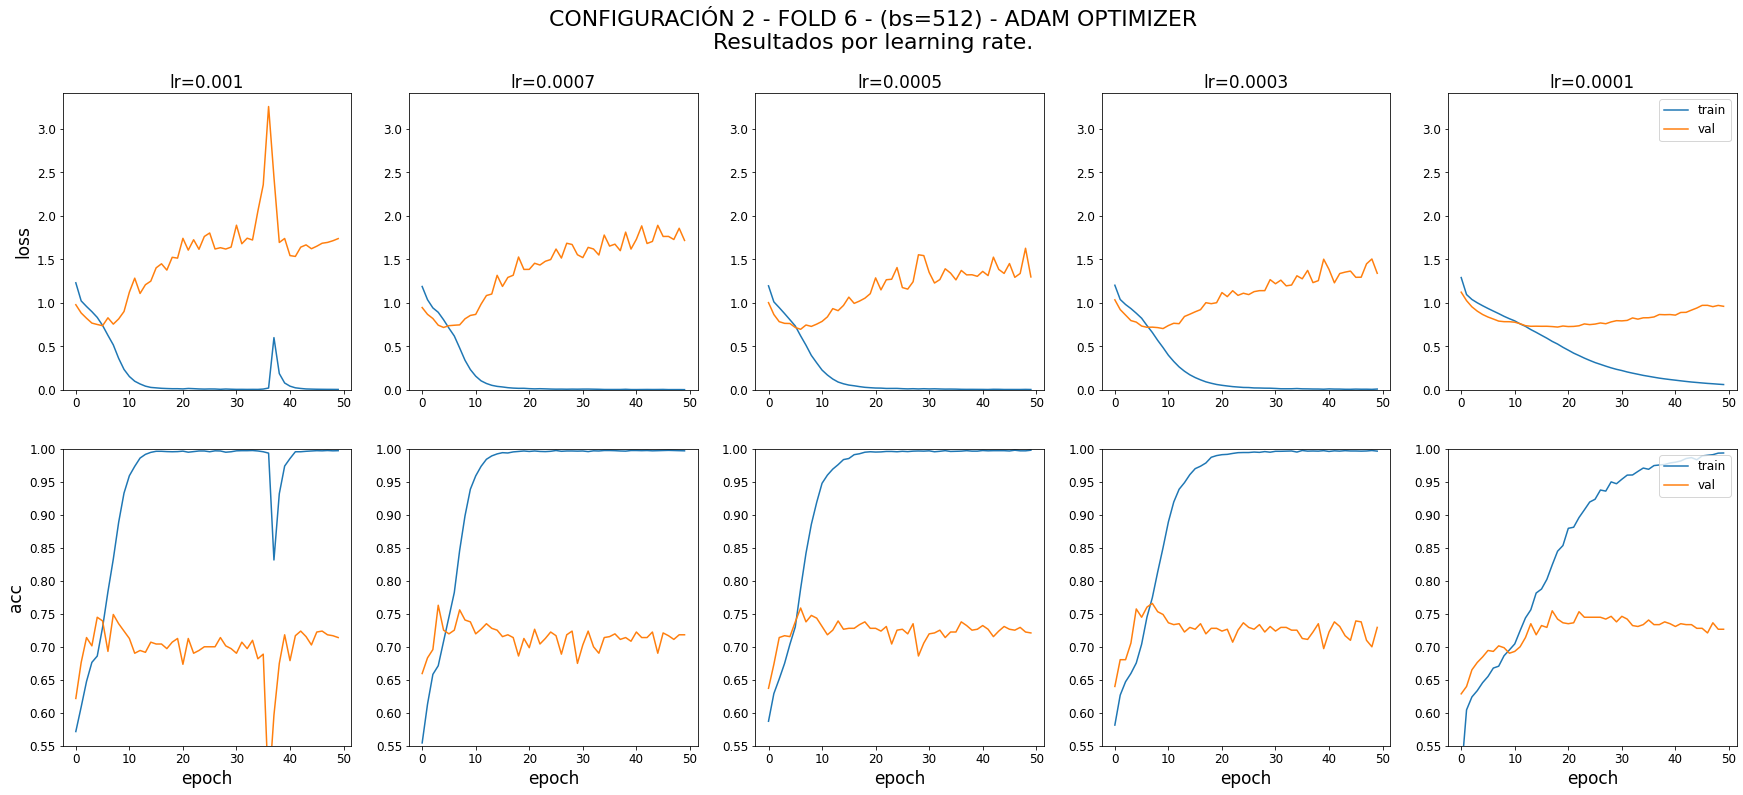

In [ ]:
folds_list = ['0', '2', '4', '6']
lr_values = ['0.001', '0.0007', '0.0005', '0.0003', '0.0001']
adam_optimizers = [f'adama-{i}' for i in [1,2,3,4,5]]

conf_n = 2
batch_size = 512

results_subset = results_df.loc[(results_df['conf_#']==conf_n)&(results_df['batch_size']==batch_size)]
ids_list = results_subset['conf_ID'].to_list()

for idx in range(4):
  histories_list = []
  for conf_id in ids_list:
    with open(f'./history_files/{conf_id}.dict', 'rb') as file_handler:
      histories_list.append(pickle.load(file_handler)[idx])

  fig_title = f'CONFIGURACIÓN {conf_n} - FOLD {folds_list[idx]} - (bs={batch_size}) - ADAM OPTIMIZER'
  fig_title += '\nResultados por learning rate.'
  plotHistories(histories_list, 
                fig_title, 
                columns_titles=[f'lr={lr}' for lr in lr_values], 
                figure_size='display_size')

### Batch size comparison

In [ ]:
folds_list = ['0', '2', '4', '6']
batch_sizes = [256,512,768,1024]

lr_values = ['0.001', '0.0007', '0.0005', '0.0003', '0.0001']
adam_optimizers = [f'adama-{i}' for i in [1,2,3,4,5]]

conf_n = 3
optimizer_id = 'adam-4'
lr = 0.0003

results_subset = results_df.loc[(results_df['conf_#']==conf_n)&(results_df['optimizer']==optimizer_id)]
ids_list = results_subset['conf_ID'].to_list()

for idx in range(len(folds_list)):
  histories_list = []
  for conf_id in ids_list:
    with open(f'./history_files/{conf_id}.dict', 'rb') as file_handler:
      histories_list.append(pickle.load(file_handler)[idx])

  fig_title = f'CONFIGURACIÓN {conf_n} - FOLD {folds_list[idx]} - ADAM OPTIMIZER (lr = {lr})'
  fig_title += '\nResultados por tamaño del batch.'
  plotHistories(histories_list, 
                fig_title, 
                columns_titles=[f'bs={bs}' for bs in batch_sizes], 
                figure_size='display_size')

## RMSPROP

In [ ]:
with open('./Results/CNN_RMSPROP_OPTIMIZER_MERGED_1.df', 'rb') as df_file:
  results_df = pickle.load(df_file)

In [ ]:
results_df.shape

(48, 17)

In [ ]:
results_df.head()

### Learning rates comparison

## momentum = 0

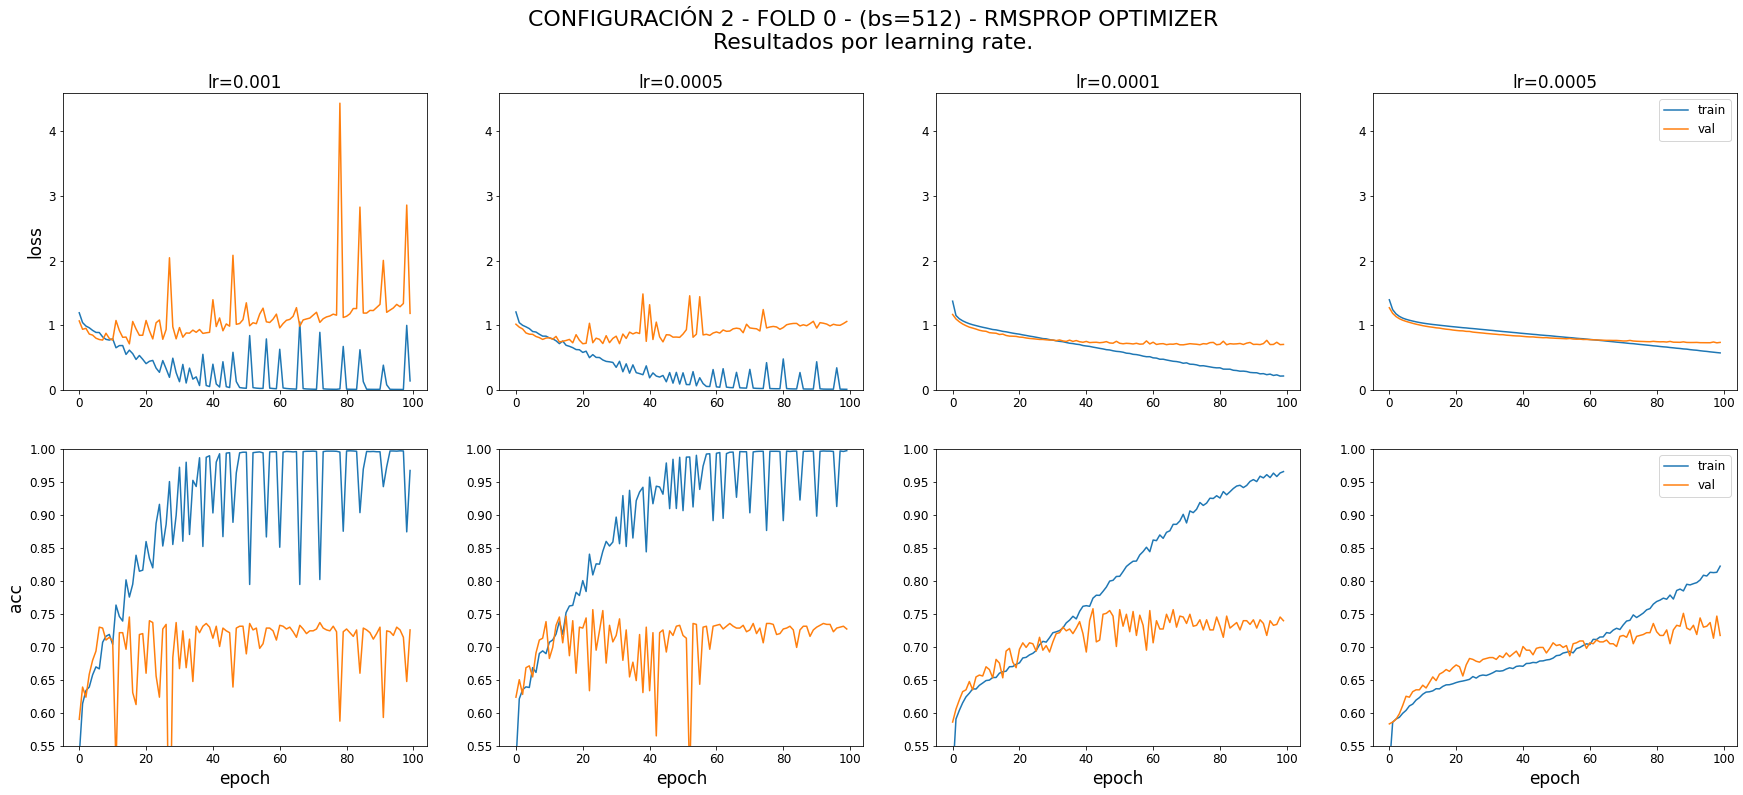

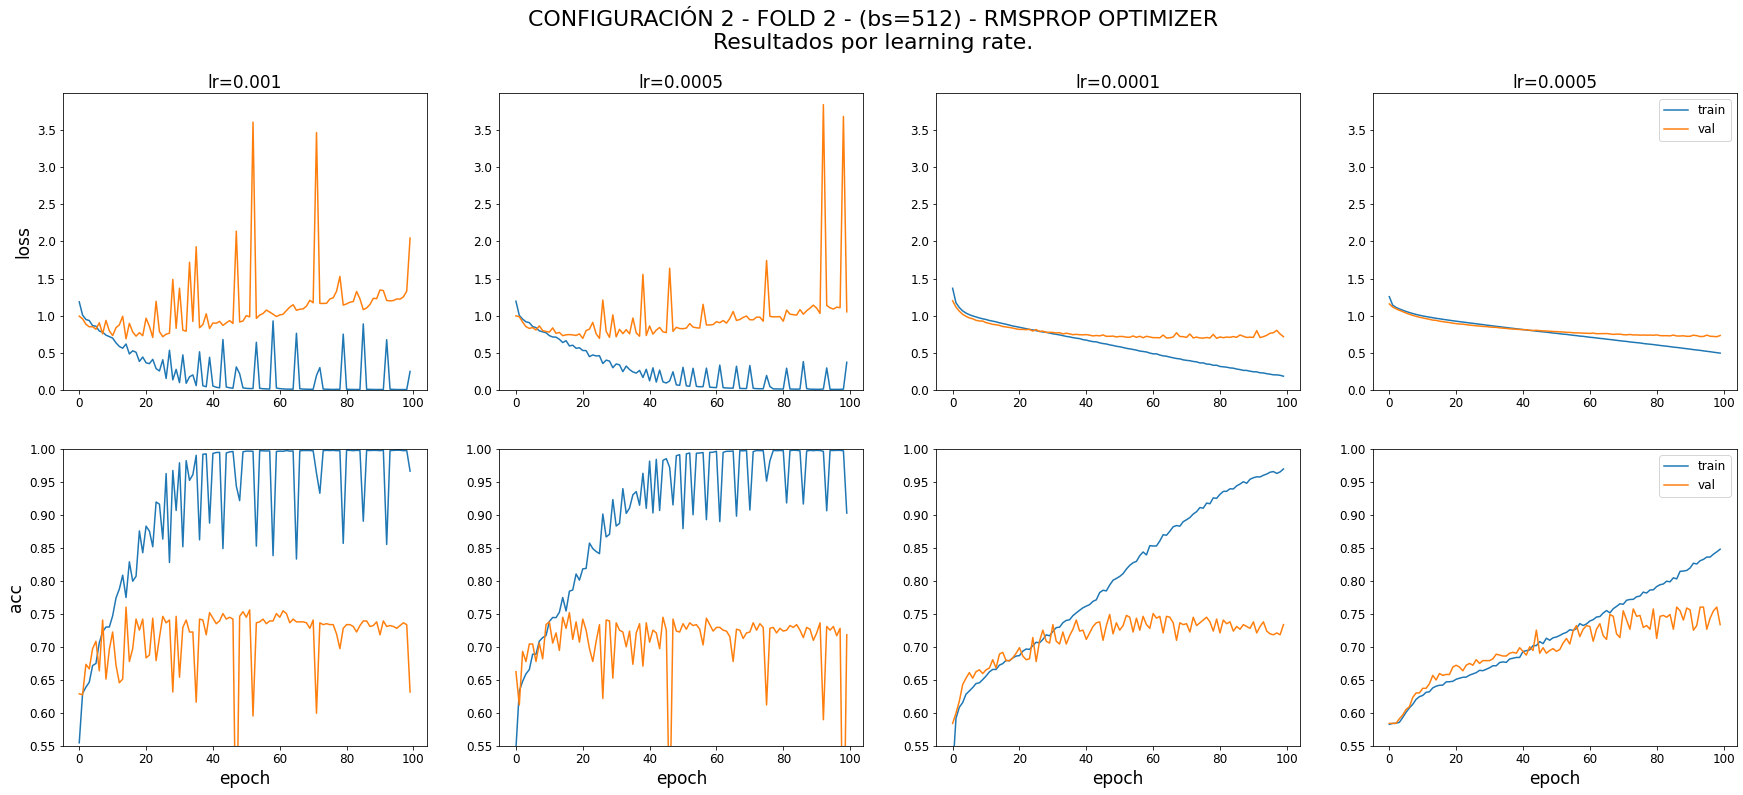

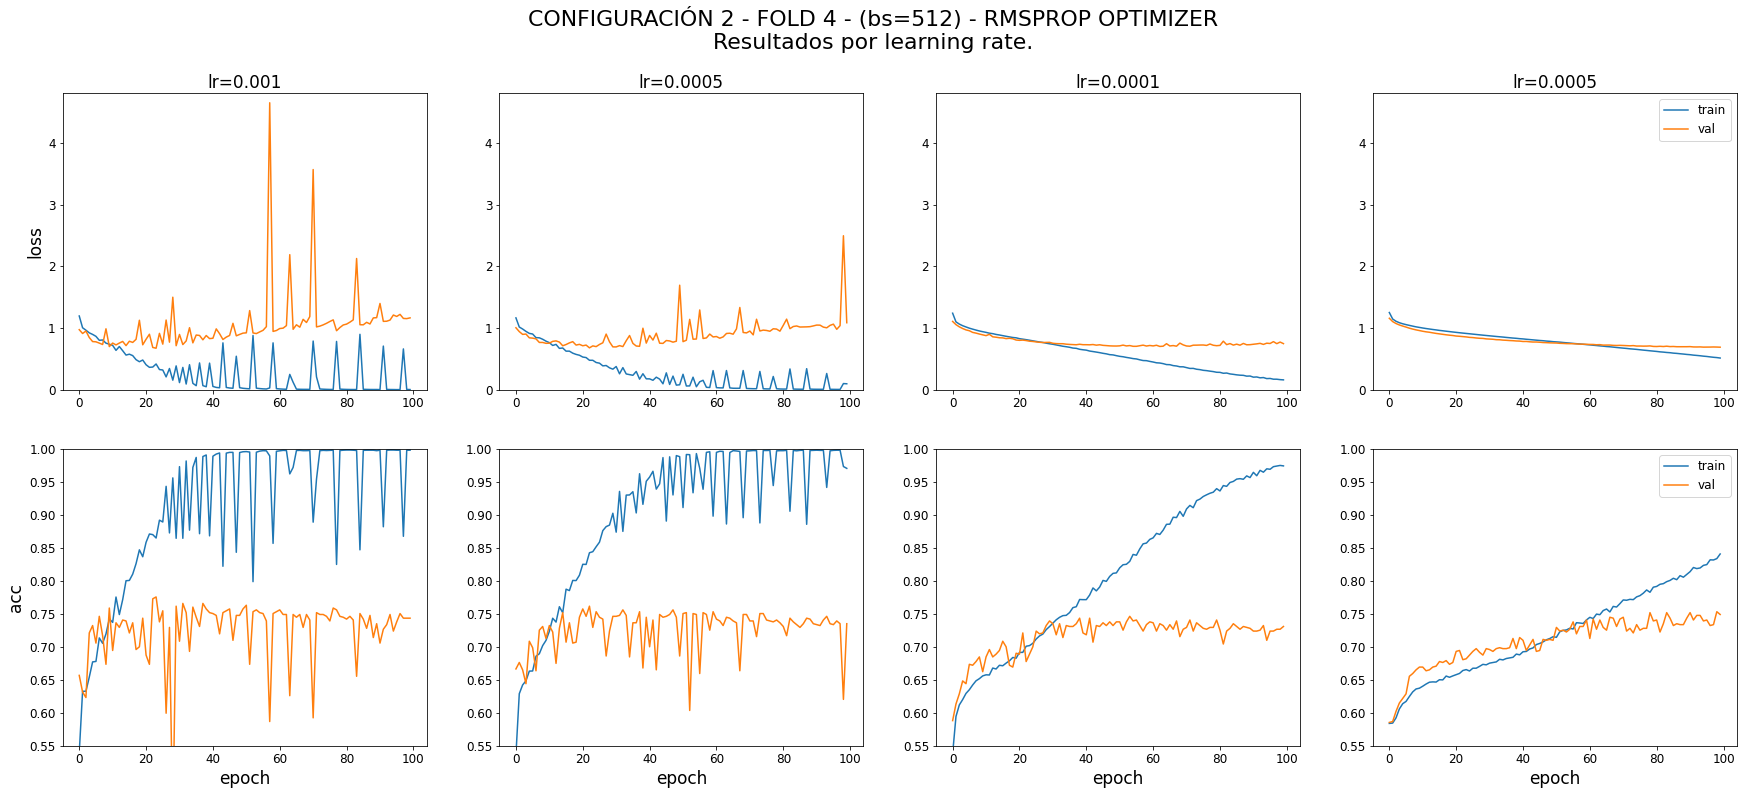

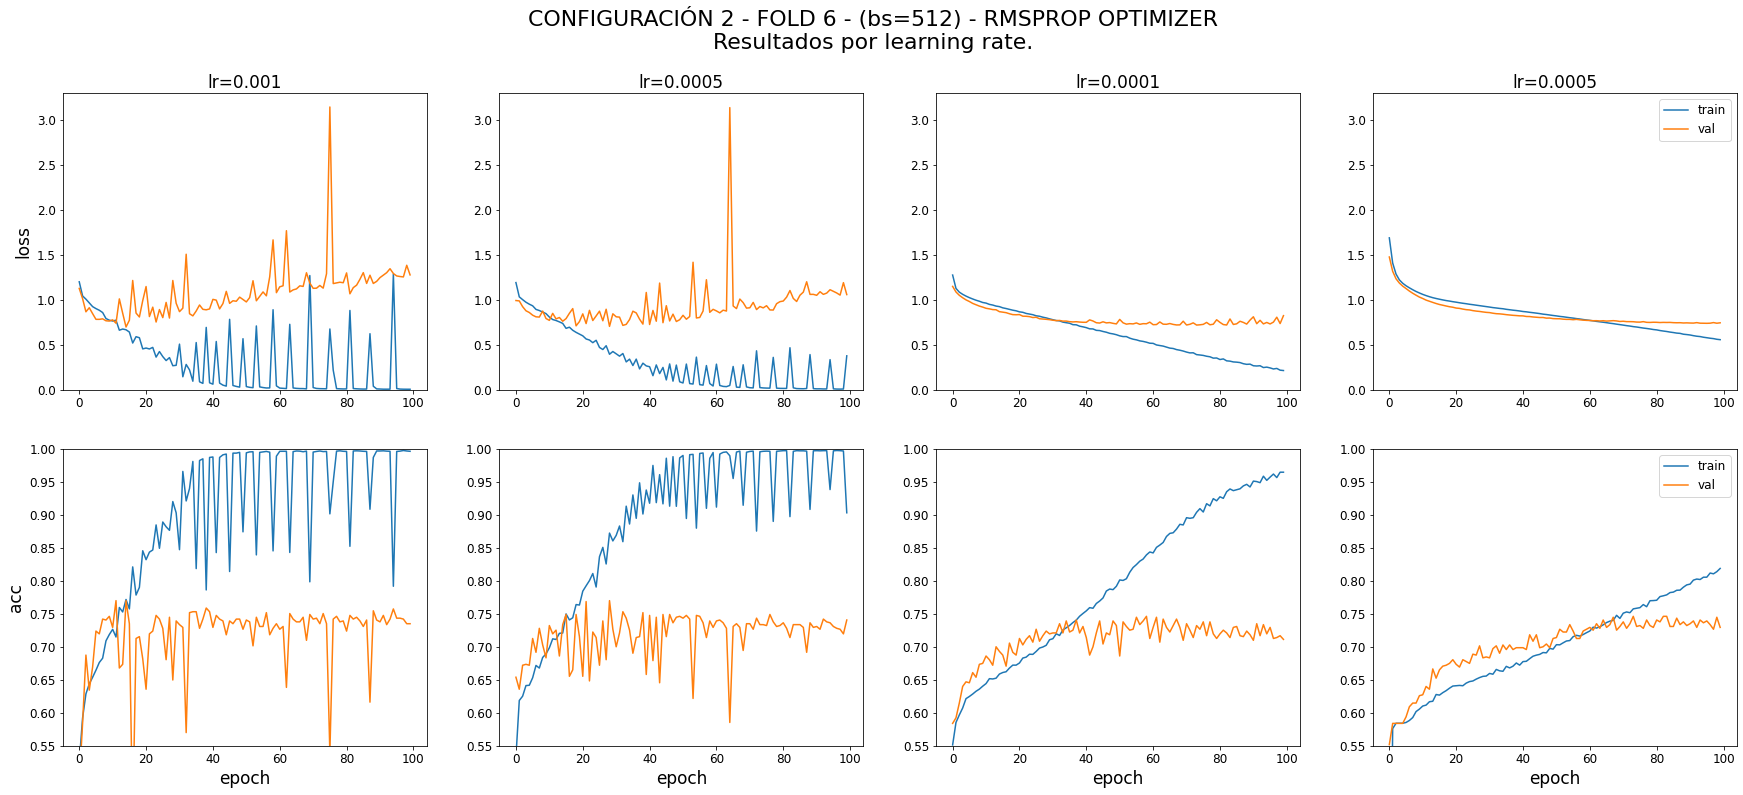

In [ ]:
folds_list = ['0', '2', '4', '6']
lr_values = ['0.001', '0.0005', '0.0001', '0.0005']
momentum = '0.9' 

adam_optimizers = [f'rmsprop-{i}' for i in [1,3,5,7]]

conf_n = 2
batch_size = 512

results_subset = results_df.loc[(results_df['conf_#']==conf_n)&
                                (results_df['batch_size']==batch_size)&
                                (results_df['optimizer'].isin(adam_optimizers))]

ids_list = results_subset['conf_ID'].to_list()

for idx in range(4):
  histories_list = []
  for conf_id in ids_list:
    with open(f'./history_files/{conf_id}.dict', 'rb') as file_handler:
      histories_list.append(pickle.load(file_handler)[idx])

  fig_title = f'CONFIGURACIÓN {conf_n} - FOLD {folds_list[idx]} - (bs={batch_size}) - RMSPROP OPTIMIZER'
  fig_title += '\nResultados por learning rate.'
  plotHistories(histories_list, 
                fig_title, 
                columns_titles=[f'lr={lr}' for lr in lr_values], 
                figure_size='display_size')

## momentum = 0.9

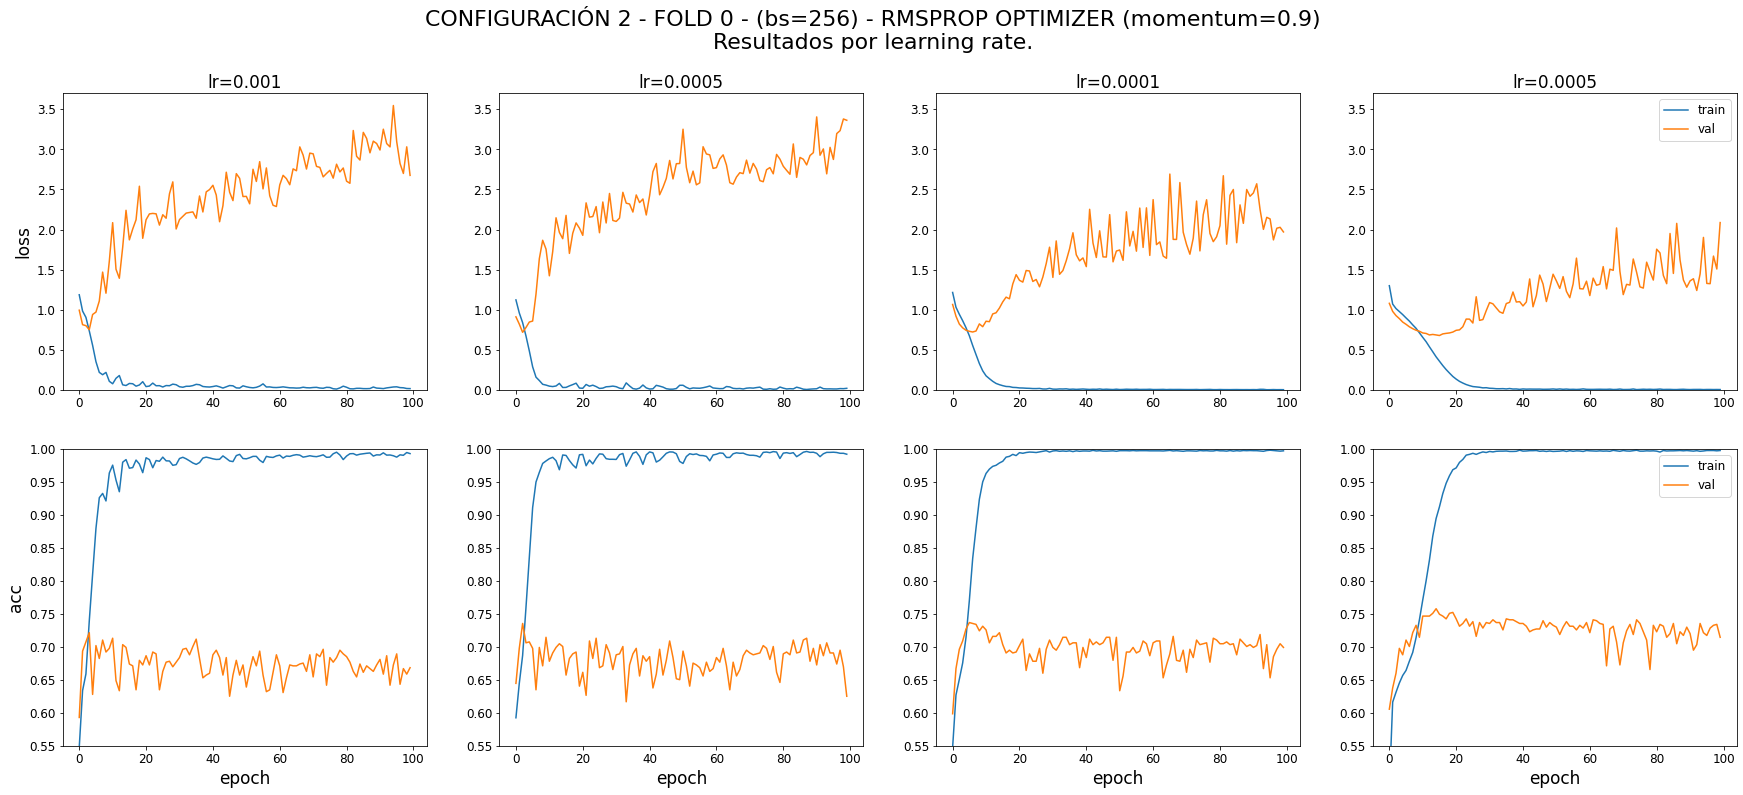

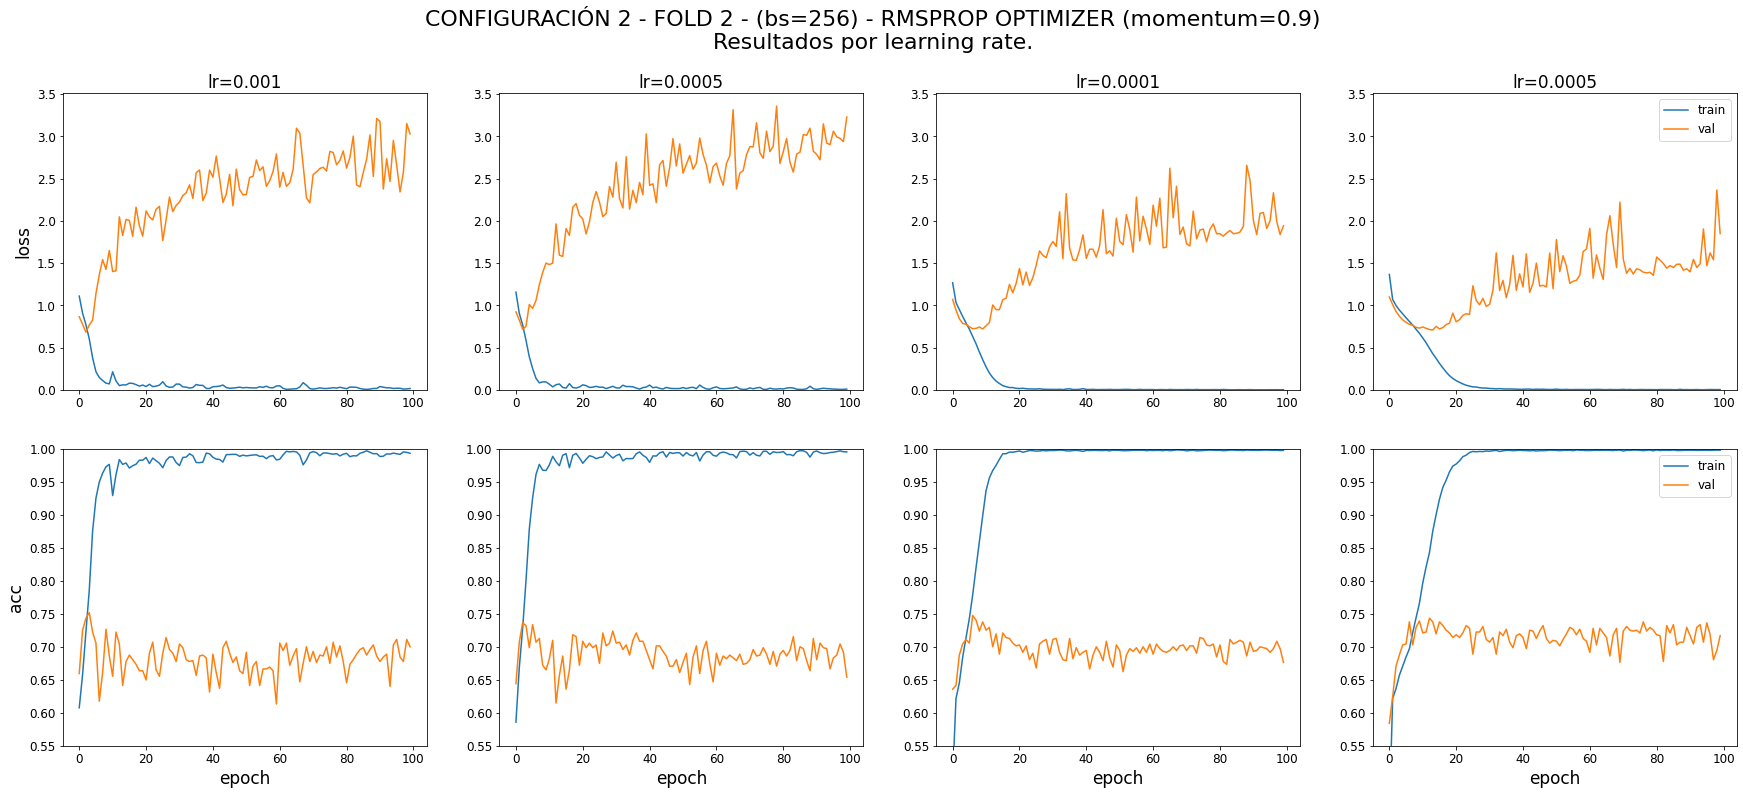

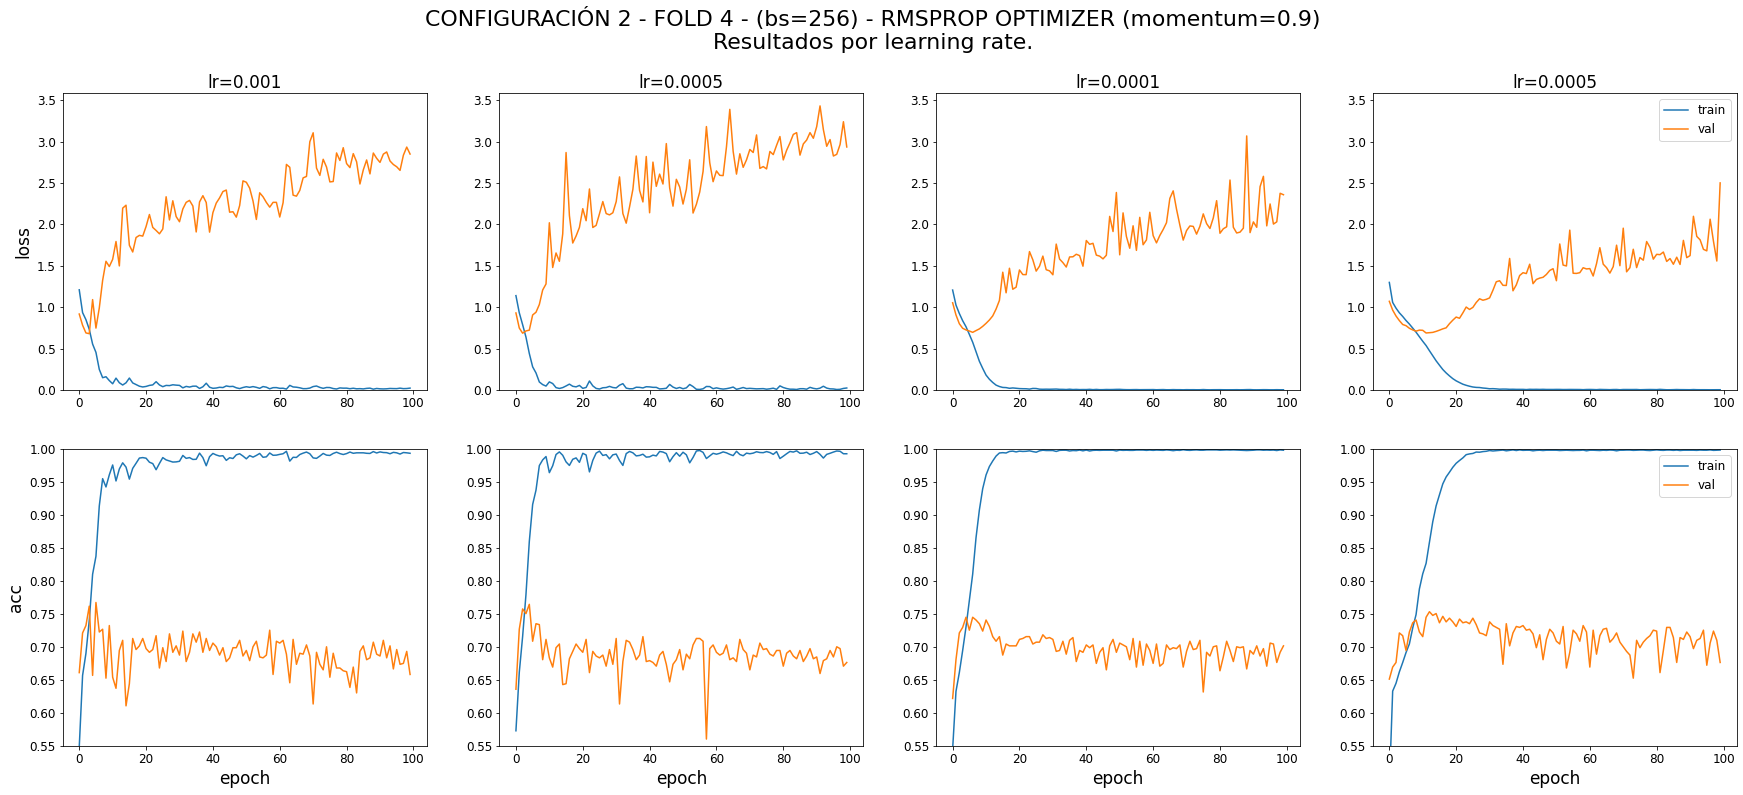

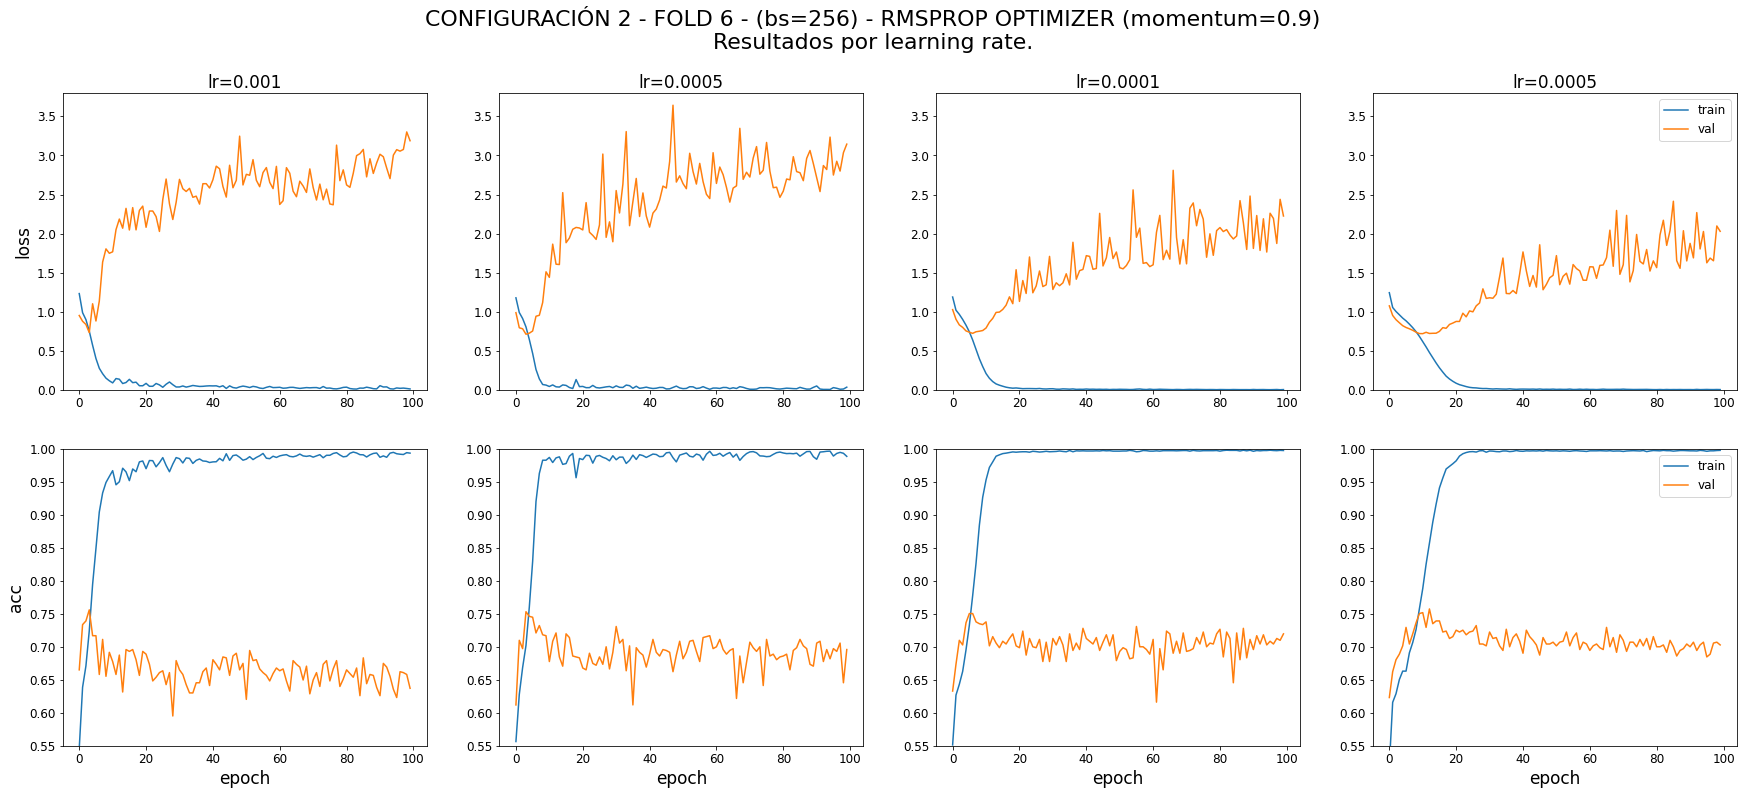

In [ ]:
folds_list = ['0', '2', '4', '6']
lr_values = ['0.001', '0.0005', '0.0001', '0.0005']
momentum = '0.9' 

adam_optimizers = [f'rmsprop-{i}' for i in [8,10,12,14]]

conf_n = 2
batch_size = 256

results_subset = results_df.loc[(results_df['conf_#']==conf_n)&
                                (results_df['batch_size']==batch_size)&
                                (results_df['optimizer'].isin(adam_optimizers))]
                                
ids_list = results_subset['conf_ID'].to_list()

for idx in range(4):
  histories_list = []
  for conf_id in ids_list:
    with open(f'./history_files/{conf_id}.dict', 'rb') as file_handler:
      histories_list.append(pickle.load(file_handler)[idx])

  fig_title = f'CONFIGURACIÓN {conf_n} - FOLD {folds_list[idx]} - (bs={batch_size}) - RMSPROP OPTIMIZER (momentum=0.9)'
  fig_title += '\nResultados por learning rate.'
  plotHistories(histories_list, 
                fig_title, 
                columns_titles=[f'lr={lr}' for lr in lr_values], 
                figure_size='display_size')

In [ ]:
results_subset = results_df.loc[results_df['optimizer'].isin(adam_optimizers)]

### Batch size comparison

In [ ]:
folds_list = ['0', '2', '4', '6']
batch_sizes = [256,512,768,1024]

lr_values = ['0.001', '0.0007', '0.0005', '0.0003', '0.0001']
adam_optimizers = [f'adama-{i}' for i in [1,2,3,4,5]]

conf_n = 3
optimizer_id = 'adam-4'
lr = 0.0003

results_subset = results_df.loc[(results_df['conf_#']==conf_n)&(results_df['optimizer']==optimizer_id)]
ids_list = results_subset['conf_ID'].to_list()

for idx in range(len(folds_list)):
  histories_list = []
  for conf_id in ids_list:
    with open(f'./history_files/{conf_id}.dict', 'rb') as file_handler:
      histories_list.append(pickle.load(file_handler)[idx])

  fig_title = f'CONFIGURACIÓN {conf_n} - FOLD {folds_list[idx]} - ADAM OPTIMIZER (lr = {lr})'
  fig_title += '\nResultados por tamaño del batch.'
  plotHistories(histories_list, 
                fig_title, 
                columns_titles=[f'bs={bs}' for bs in batch_sizes], 
                figure_size='display_size')

In [ ]:
ids_list

['LDcrOG', 'aVhfcn', 'ZQbRRM', 'LDfmmS', 'aKDGMC']

In [ ]:
with open(f'./history_files/{conf_id}.dict', 'rb') as file_handler:
  histories_list = pickle.load(file_handler)

In [ ]:
with open(f'./history_files/gsFmsD.dict', 'rb') as file_handler:
  histories_list = pickle.load(file_handler)

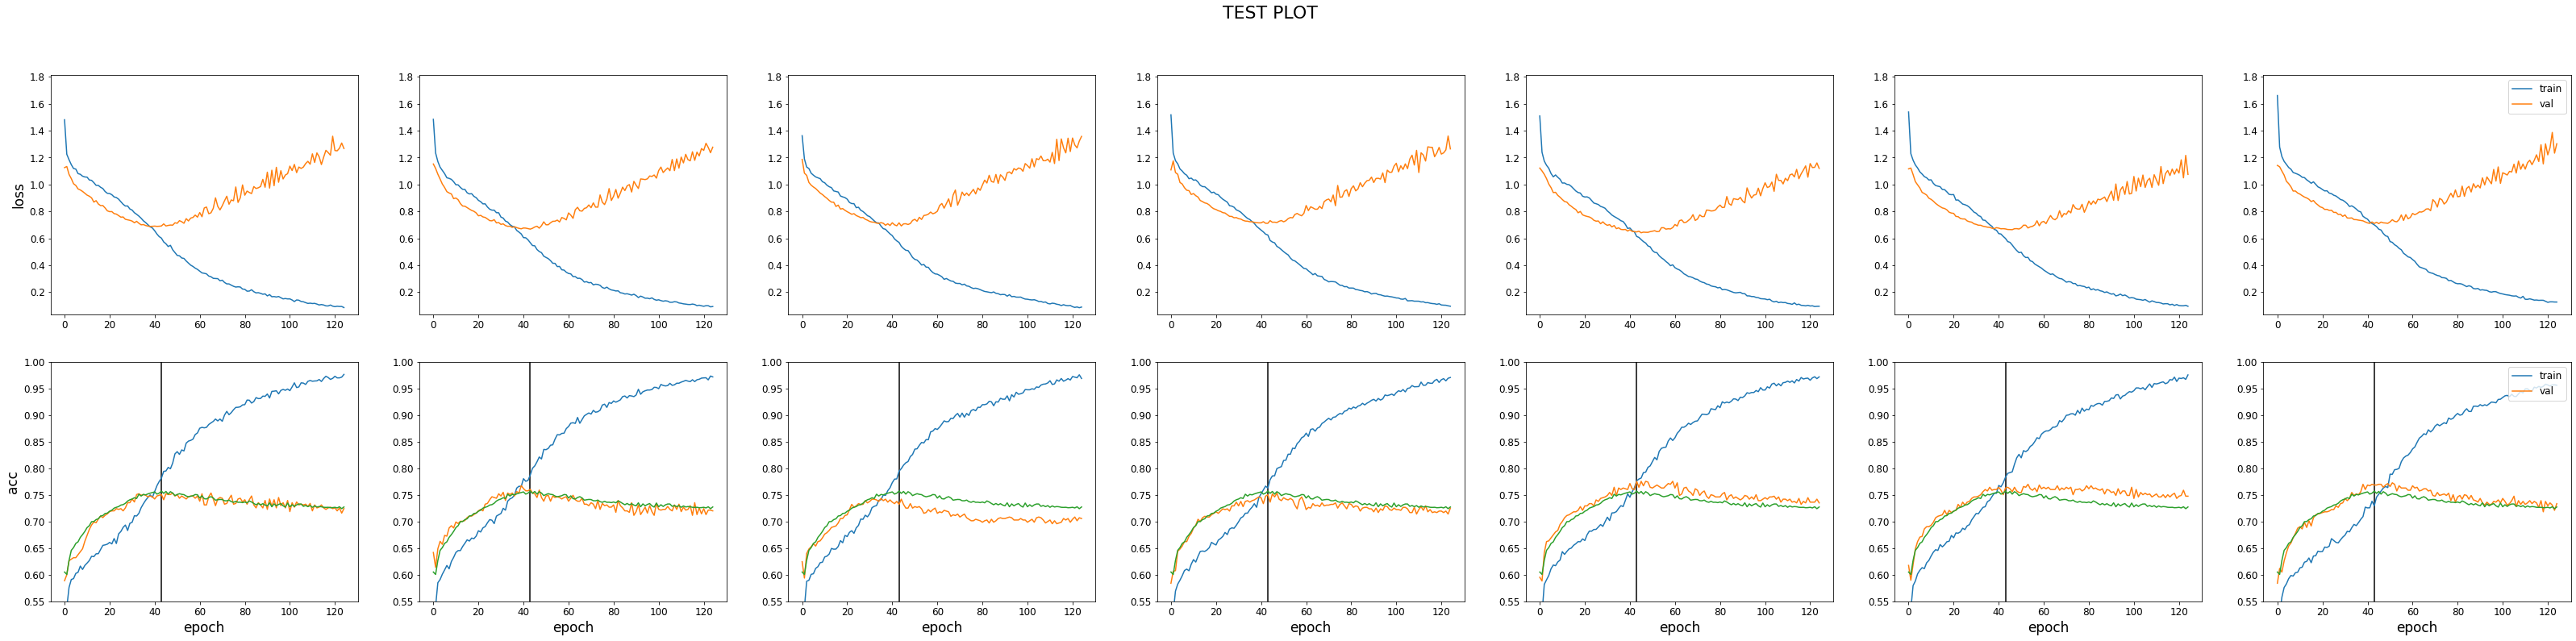

In [ ]:
fig_title = f'TEST PLOT'

plotHistories(histories_list[:], 
              fig_title, 
              columns_titles=[], 
              figure_size='display_size',
              plot_mean_val_acc=True,
              plot_best_epoch=True)

In [ ]:
plotHistories(histories_list, 'Test title', [], figure_size='display_size')

# Architecture Search Results

### getParametersFronIndex()

In [ ]:
arch_params_keys = ['kernels_sizes', 
                    'n_filters', 
                    'conv_layers_activation', 
                    'pooling_method', 
                    'spatial_dropout', 
                    'dense_layers_sizes', 
                    'dense_dropout']

trainig_params_keys=['optimizer', 'batch_size', 'max_epochs']

def getParametersFronIndex(results_df, idx):
  arch_params = results_df.loc[idx,arch_params_keys].to_list()
  trainig_params = results_df.loc[idx,trainig_params_keys].to_list()

  return [(arch_params), (trainig_params)]

## Adam-4

### Merge the results

In [ ]:
files_list = ['./Results/CNN_ARCH_SEARCH_EXP_1.df',
            './Results/CNN_ARCH_SEARCH_EXP_2.df',
            './Results/CNN_ARCH_SEARCH_EXP_3.df',
            './Results/CNN_ARCH_SEARCH_EXP_ADAM4_1.df']

merged_results = results_utils.mergeDataFrames(files_list, './Results/CNN_ARCH_SEARCH_MERGED.df') 

### Import the results file

In [ ]:
with open('./Results/CNN_ARCH_SEARCH_ADAM4_MERGED.df', 'rb') as file_handler:
  results_df = pickle.load(file_handler)

In [ ]:
results_df.shape()

In [ ]:
results_df.head()

### Compute the best epoch for every configuration

In [ ]:
for idx in results_df.index:
  conf_id =results_df.loc[idx,'conf_ID']
  with open(f'./history_files/{conf_id}.dict', 'rb') as file_handler:
    histories_list = pickle.load(file_handler)

  mean_val_acc = computeMeanValAcc(histories_list)
  best_epoch = mean_val_acc.index(max(mean_val_acc))

  results_df.loc[idx,'best_epoch_1']=best_epoch

### Take those wher 'val_acc' >= 0.755

In [ ]:
results_df.loc[merged_results['val_acc']>=0.755].shape

(24, 16)

In [ ]:
df_subset = results_df.loc[(results_df['val_acc']>=0.755)]
index_list = df_subset.index.to_list()
ids_list = df_subset['conf_ID'].to_list()

for i, conf_id in enumerate(ids_list[:], start=0):
  with open(f'./history_files/{conf_id}.dict', 'rb') as file_handler:
    histories_list = pickle.load(file_handler)

  fig_title = f'Index: {index_list[i]} - ConfID: {conf_id}'
  plotHistories(histories_list[:], 
              fig_title, 
              columns_titles=[f'fold {i}' for i in range(7)], 
              figure_size='display_size',
              plot_mean_val_acc=True,
              plot_best_epoch=True,
              save_figure=True,
              file_name=conf_id,
              hide_figure=True
              )

### Get the parameters of the chosen configurations

In [ ]:
IDX_LIST = [149, 104, 94, 90, 76, 70, 62]

In [ ]:
results_df.loc[IDX_LIST,:]

conf_ID kernels_sizes  n_filters  ...   val_acc val_acc_std  best_epoch_1
149  HQyZba     (1, 2, 3)        100  ...  0.756003    0.006638            20
104  CilflW     (1, 2, 3)        100  ...  0.755400    0.010069            28
94   lEcqXI     (1, 2, 3)        150  ...  0.761402    0.007892            15
90   jecVmy     (1, 2, 3)         50  ...  0.757804    0.008987            25
76   EYVHAM     (1, 2, 3)         50  ...  0.756404    0.008355            13
70   GgHPFb     (1, 2, 3)        100  ...  0.758001    0.009239            19
62   HdnFSS     (1, 2, 3)        100  ...  0.757404    0.011509            33

[7 rows x 17 columns]

In [ ]:
models_params = []
epochs2watch = []
conf_ids = []
for idx in IDX_LIST:
  models_params.append(getParametersFronIndex(results_df, idx))
  epochs2watch.append(results_df.loc[idx, 'best_epoch_1'])
  conf_ids.append(results_df.loc[idx, 'conf_ID'])

In [ ]:
conf_ids

['HQyZba', 'CilflW', 'lEcqXI', 'jecVmy', 'EYVHAM', 'GgHPFb', 'HdnFSS']

## Adam-5

### Merge the results

In [ ]:
files_list = ['./Results/CNN_ARCH_SEARCH_EXP_ADAM5_1.df',
            './Results/CNN_ARCH_SEARCH_EXP_ADAM5_2.df',
            './Results/CNN_ARCH_SEARCH_EXP_ADAM5_3.df']

merged_results = results_utils.mergeDataFrames(files_list, './Results/CNN_ARCH_SEARCH_ADAM5_MERGED.df') 

### Import the results file

In [ ]:
with open('./Results/CNN_ARCH_SEARCH_ADAM5_MERGED.df', 'rb') as file_handler:
  results_df = pickle.load(file_handler)

In [ ]:
results_df.shape

(90, 16)

### Compute the best epoch for every configuration

In [ ]:
results_df['best_epoch_1']=0

In [ ]:
for idx in results_df.index:
  conf_id =results_df.loc[idx,'conf_ID']
  with open(f'./history_files/{conf_id}.dict', 'rb') as file_handler:
    histories_list = pickle.load(file_handler)

  mean_val_acc = computeMeanValAcc(histories_list)
  best_epoch = mean_val_acc.index(max(mean_val_acc))

  results_df.loc[idx,'best_epoch_1']=best_epoch

### Take those wher 'val_acc' >= 0.755

In [ ]:
results_df.loc[results_df['val_acc']>=0.75].shape

(34, 17)

In [ ]:
results_df.head()

conf_ID kernels_sizes  n_filters  ...   val_acc val_acc_std  best_epoch_1
0  UQlDtm     (1, 2, 3)        150  ...  0.719820    0.046295         124.0
1  oCsqjn     (1, 2, 3)        150  ...  0.744203    0.008984          16.0
2  LCzTSv     (1, 2, 3)        100  ...  0.750801    0.005411          43.0
3  NGungi     (1, 2, 3)        100  ...  0.738601    0.006327          26.0
4  XdTBxB     (1, 2, 3)        100  ...  0.739601    0.008096         100.0

[5 rows x 17 columns]

In [ ]:
df_subset = results_df.loc[(results_df['val_acc']>=0.75)]
index_list = df_subset.index.to_list()
ids_list = df_subset['conf_ID'].to_list()

for i, conf_id in enumerate(ids_list[:], start=0):
  with open(f'./history_files/{conf_id}.dict', 'rb') as file_handler:
    histories_list = pickle.load(file_handler)

  fig_title = f'Index: {index_list[i]} - ConfID: {conf_id}'
  plotHistories(histories_list[:], 
              fig_title, 
              columns_titles=[f'fold {i}' for i in range(7)], 
              figure_size='display_size',
              plot_mean_val_acc=True,
              plot_best_epoch=True,
              save_figure=True,
              file_name=conf_id,
              hide_figure=True
              )

In [ ]:
results_df.sort_values(by='val_acc', ascending=False).head()

conf_ID kernels_sizes  n_filters  ...   val_acc val_acc_std  best_epoch_1
73  wEcjHR     (1, 2, 3)        150  ...  0.763000    0.006018            41
33  EdfjyI     (1, 2, 3)        150  ...  0.762002    0.010253            66
50  xKcGlz     (1, 2, 3)        150  ...  0.760602    0.012331            15
23  FxXjyt     (1, 2, 3)        150  ...  0.758599    0.008814            47
70  kdnejw     (1, 2, 3)        150  ...  0.757799    0.007072            76

[5 rows x 17 columns]

### Get the parameters of the chosen configurations

In [ ]:
IDX_LIST = [73, 70, 49, 47, 45, 44, 43, 41, 40, 33, 37, 18]

In [ ]:
results_df.loc[IDX_LIST,:]

conf_ID kernels_sizes  n_filters  ...   val_acc val_acc_std  best_epoch_1
73  wEcjHR     (1, 2, 3)        150  ...  0.763000    0.006018          41.0
70  kdnejw     (1, 2, 3)        150  ...  0.757799    0.007072          76.0
49  vmgIce     (1, 2, 3)         50  ...  0.750601    0.005085          54.0
47  CODsNb     (1, 2, 3)        100  ...  0.751599    0.004687          41.0
45  CFkFKl     (1, 2, 3)        150  ...  0.754800    0.004935          56.0
44  grwiAN     (1, 2, 3)        150  ...  0.756999    0.006152          45.0
43  SUmaLC     (1, 2, 3)        100  ...  0.757400    0.003928          55.0
41  xBygYt     (1, 2, 3)        100  ...  0.753200    0.003607          83.0
40  pGkuLE     (1, 2, 3)        100  ...  0.754400    0.010375          68.0
33  EdfjyI     (1, 2, 3)        150  ...  0.762002    0.010253          66.0
37  bVrHNd     (1, 2, 3)        100  ...  0.754599    0.004857          56.0
18  fwcMlE     (1, 2, 3)         50  ...  0.754599    0.006772          41.0

[12 rows x 17 columns]

In [ ]:
models_params = []
epochs2watch = []
conf_ids = []
for idx in IDX_LIST:
  models_params.append(getParametersFronIndex(results_df, idx))
  epochs2watch.append(results_df.loc[idx, 'best_epoch_1'])
  conf_ids.append(results_df.loc[idx, 'conf_ID'])

In [ ]:
models_params

[[[(1, 2, 3), 150, 'tanh', 'max', 0.6, (300, 100), 0.0], ['adam-5', 768, 56]],
 [[(1, 2, 3), 150, 'relu', 'max', 0.6, (450, 150), 0.6], ['adam-5', 512, 91]],
 [[(1, 2, 3), 50, 'tanh', 'max', 0.6, (450, 150), 0.3], ['adam-5', 512, 69]],
 [[(1, 2, 3), 100, 'tanh', 'max', 0.6, (150, 50), 0.0], ['adam-5', 512, 56]],
 [[(1, 2, 3), 150, 'relu', 'max', 0.3, (300, 100), 0.6], ['adam-5', 512, 71]],
 [[(1, 2, 3), 150, 'relu', 'max', 0.3, (450, 150), 0.6], ['adam-5', 512, 60]],
 [[(1, 2, 3), 100, 'relu', 'max', 0.6, (150, 50), 0.0], ['adam-5', 768, 70]],
 [[(1, 2, 3), 100, 'tanh', 'max', 0.6, (150, 50), 0.3], ['adam-5', 768, 98]],
 [[(1, 2, 3), 100, 'tanh', 'max', 0.6, (150, 50), 0.0], ['adam-5', 768, 83]],
 [[(1, 2, 3), 150, 'relu', 'max', 0.6, (150, 50), 0.3], ['adam-5', 512, 81]],
 [[(1, 2, 3), 100, 'relu', 'max', 0.6, (150, 50), 0.0], ['adam-5', 512, 71]],
 [[(1, 2, 3), 50, 'tanh', 'max', 0.6, (300, 100), 0.0], ['adam-5', 512, 56]]]

In [ ]:
for i, row in enumerate(models_params):
  row[1][2]=int(epochs2watch[i]+15)

In [ ]:
epochs2watch = [int(i) for i in epochs2watch]

In [ ]:
epochs2watch

[41, 76, 54, 41, 56, 45, 55, 83, 68, 66, 56, 41]

In [ ]:
conf_ids

['wEcjHR',
 'kdnejw',
 'vmgIce',
 'CODsNb',
 'CFkFKl',
 'grwiAN',
 'SUmaLC',
 'xBygYt',
 'pGkuLE',
 'EdfjyI',
 'bVrHNd',
 'fwcMlE']

# OTHER STUFF

In [ ]:
#fig_title = f'({conf_id}) Configuración 3 - ADAM optimizer lr ={lr_values[idx]}'
fig_title = f'({conf_id}) Configuración 3 - RMSprop optimizer lr ={lr_values[idx]}'
#fig_title = f'Configuración 3 - ADAM optimizer

In [ ]:
#fig_title = f'({conf_id}) Configuración 3 - ADAM optimizer lr ={lr_values[idx]}'
fig_title = f'({conf_id}) Configuración 3 - RMSprop optimizer lr ={lr_values[idx]}'
#fig_title = f'Configuración 3 - ADAM optimizer'

plot_mov_avg = False
fig, ax = plt.subplots(2, len(histories_list), figsize=(30, 12))
#fig, ax = plt.subplots(2, len(h6_list), figsize=(30, 12))

ax[0, 0].set_ylabel('loss')
ax[1, 0].set_ylabel('acc')

max_loss = 0
min_loss = 1
max_acc = 0
min_acc = 1

for i, model_history in enumerate(histories_list):
  df = pd.DataFrame(model_history)

  max_loss = max(max_loss, df['loss'].max(), df['val_loss'].max())
  max_acc  = max(max_acc, df['acc'].max(), df['val_acc'].max())
  min_loss = min(min_loss, df['loss'].min(), df['val_loss'].min())
  min_acc  = min(min_acc, df['acc'].min(), df['val_acc'].min())

  if plot_mov_avg:
    df['val_acc_SMA'] = df['val_acc'].rolling(window=rolling_window).mean()
    df['val_loss_SMA'] = df['val_loss'].rolling(window=rolling_window).mean()

  ax[0, i].plot(model_history['loss'])
  ax[0, i].plot(model_history['val_loss'])
  if plot_mov_avg:
    ax[0, i].plot(df['val_loss_SMA'])
  
  #ax[0, i].set_title(f'lr: {lr_values[i]}')
  #ax[0, i].set_ylabel('loss')
  #ax[0, i].set_xlabel('epoch')
  #ax1.set_ylim(.2, 1.2)
  #ax.set_legend(['train', 'val'], loc='upper left')
  #plt.show()
  
  ax[1, i].plot(model_history['acc'])
  ax[1, i].plot(model_history['val_acc'])
  if plot_mov_avg:
    ax[1, i].plot(df['val_acc_SMA'])
  #ax[1, i].set_title('model acc')
  #ax[1, i].set_ylabel('acc')
  ax[1, i].set_xlabel('epoch')
  #ax2.set_ylim(.55, .95)
  #ax.set_legend(['train', 'val'], loc='upper left')
  #plt.show()

for i in range(len(histories_list)):
  ax[0, i].set_ylim(max(0, min_loss - 0.05), max_loss + 0.15)
  ax[1, i].set_ylim(0.55, 1)

fig.suptitle(fig_title)
#plt.show()

In [ ]:
histories_list = []
for conf_id in ids_list:
  with open(f'./history_files/{conf_id}.dict', 'rb') as file_handler:
    histories_list.append(pickle.load(file_handler)[3])

In [ ]:
with open('./history_files/aVhfcn.dict', 'rb') as file_handler:
  histories_list = pickle.load(file_handler)

from statistics import mean, stdev

# To choose the best epoch:
#   1) Compute the mean-val-acc and val-acc-stdev for every epoch
#   2) Let M be equal to the largest mean-val-acc
#   3) Among the epochs where mean-val-acc >= (M - delta) pick the one with the 
#      smallest val-acc-stdev. 

delta = .5/100
mean_acc_values = list()
stdev_values = list()  

# Find M
max_acc = 0
max_acc_idx = 0
val_acc_zip = zip(*[h['val_acc'] for h in hist_list])

for i, val_accuracies in enumerate(val_acc_zip):
  mean_acc_values.append(mean(val_accuracies))
  stdev_values.append(stdev(val_accuracies))

  max_acc = max(max_acc, mean_acc_values[-1])

  print(i, mean_acc_values[-1], stdev_values[-1])

# Use M to pick the best epoch
best_epoch_metrics = [0, 1]
best_epoch_idx = 0

for i, epoch_metrics in enumerate(zip(mean_acc_values, stdev_values)):
  if (epoch_metrics[0] >= max_acc - delta) & (epoch_metrics[1] < best_epoch_metrics[1]):
    best_epoch_metrics = epoch_metrics
    best_epoch_idx = i

# Compute acc and acc-stdev for the chosen epoch
acc_values = list(zip(*[h['acc'] for h in hist_list]))

best_epoch_mean_acc = mean(acc_values[best_epoch_idx])
best_epoch_acc_stdev = stdev(acc_values[best_epoch_idx])


print()
print(best_epoch_idx, best_epoch_metrics)
print('mean_acc: ', best_epoch_mean_acc)
print('mean_acc_std: ', best_epoch_acc_stdev)

In [ ]:
import matplotlib.pyplot as plt

SMALL_SIZE = 10
MEDIUM_SIZE = 12
BIGGER_SIZE = 17
BIGGEST_SIZE = 20

plt.rc('font', size=MEDIUM_SIZE)         # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGEST_SIZE)  # fontsize of the figure title

In [ ]:
fig, ax = plot_histories(histories_list)

In [ ]:
plt.show()

Text(0.5, 0.98, 'Sharing x per column, y per row')

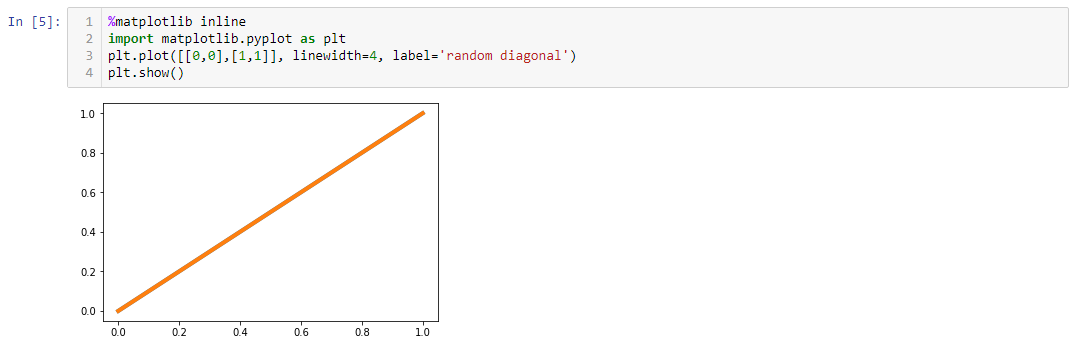

In [ ]:
pip install ipympl

In [ ]:
%matplotlib widget

In [ ]:
from matplotlib import pyplot as plt
import pandas as pd

In [ ]:
plt.plot([[0,0],[1,1]])
plt.title('hola')
plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [ ]:
for hist in hist_list:
  plot_history(hist, plot_mov_avg=False)

In [ ]:
acc_values[best_epoch_idx]

(0.7073512077331543,
 0.7181521058082581,
 0.7281847596168518,
 0.6682221293449402)

In [ ]:
for h in hist_list:
  print(h['val_acc'][best_epoch_idx])

0.737062931060791
0.7296918630599976
0.7408963441848755
0.7296918630599976


In [ ]:
import random
import string

def get_random_string(length):
    # choose from all lowercase+uppercase letters
    letters = string.ascii_lowercase + string.ascii_uppercase
    result_str = ''.join(random.choice(letters) for i in range(length))
    #print("Random string of length", length, "is:", result_str)

    return result_str

In [ ]:
print(get_random_string(6))

eOOsGZ


In [ ]:
data_fold = next(data_folds)
model = lstmPlus2DConv('HTA', model_params, opt='adam', lr=0.0005, mu=0.9)
acc, model_history = nn_utils.fitNeuralNetworkModel(model, task, 128, 
                                          100, 0.99, data=(data_fold))

print(acc) 

0.7720279693603516


In [ ]:
plot_history(model_history, 'TEST_ID', 1)

In [ ]:
model_history['acc'].rolling(window=4).mean()

In [ ]:
type(model_history)

dict

In [ ]:
import pandas as pd
df = pd.DataFrame(model_history)

In [ ]:
df['val_acc_SMA_4'] = df['val_acc'].rolling(window=4).mean()
df['val_acc_SMA_10'] = df['val_acc'].rolling(window=10).mean()

# HIPERP

In [ ]:
import tensorflow.keras.optimizers as keras_optimizers

adam_optimizers = [keras_optimizers.Adam(learning_rate=0.001),
                   keras_optimizers.Adam(learning_rate=0.0007),
                   keras_optimizers.Adam(learning_rate=0.0005),
                   keras_optimizers.Adam(learning_rate=0.0003),
                   keras_optimizers.Adam(learning_rate=0.0001)]

rmsprop_optimizers = [keras_optimizers.RMSprop(learning_rate=0.001, momentum=0.9),
                      keras_optimizers.RMSprop(learning_rate=0.0007, momentum=0.9),
                      keras_optimizers.RMSprop(learning_rate=0.0005, momentum=0.9),
                      keras_optimizers.RMSprop(learning_rate=0.0003, momentum=0.9),
                      keras_optimizers.RMSprop(learning_rate=0.0001, momentum=0.9)]                  

In [ ]:
from itertools import product

kernel_sizes = [(1,2,3)]

dense_layers_sizes = [(450,150),
                      (300,100),
                      (250,100),
                      (150,50)]    

optimizers = [adam_optimizers[1],
              adam_optimizers[2],
              adam_optimizers[3],
              adam_optimizers[4]]                                     

params_dict = {'kernel_sizes':kernel_sizes,
               'n_filters':[50, 100, 150],
               'conv_layers_activation':['tanh'],
               'pooling_method':['max'],
               'spatial_dropout':[0, 0.3, 0.6],
               'dense_layers_sizes':dense_layers_sizes,
               'dense_dropout':[0,0.3,0.6],
               'optimizer':optimizers,
               'batch_size':[512]}

search_space = list(product(*params_dict.values()))

print('{} permutations in the search space.'.format(len(search_space)))   

432 permutations in the search space.
